# Recomendador de inversiones inmoviliarias

## Datos origen:

- [Precio_medio_EUR_m2_alquiler](datasets/Precio_medio_EUR_m2_alquiler.csv)
- [Precio_medio_EUR_m2_compraventa](datasets/Precio_medio_EUR_m2_compraventa.csv)
- [BarcelonaCiutat_SeccionsCensals](datasets/BarcelonaCiutat_SeccionsCensals.csv)
- [idealista_datafile](datasets/idealista_datafile.csv)


## Tareas:

1. Dentificar toda la jerarquia de distritos y barrios
1. Modelo de ML para extrapolar precios estadístico de alquiler y compraventa a fecha de hoy
1. Asignar precio estadístico de alquiler y compraventa a cada inmueble basado en su barrio o distrito
1. Crear una puntuación para cada barrio o distrito de 0 a 1
1. Crear una puntuación para el precio de compra para cada inmueble de 0 a 1 en función del precio estadístico de compra de cada barrio o distrito
1. Crear una puntuación para el precio de alquiler para cada inmueble de 0 a 1 en función del precio estadístico de alquiler de cada barrio o distrito
1. Calcular la tasa de retorno de cada inmueble en función del precio de compra y el precio de alquiler
1. Crear una puntuación final para cada inmueble de 0 a 1 en función de las puntuaciones anteriores


In [28]:
!pip install openpyxl scikit-learn

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')


## Carga de datos de Barcelona Datos con el Precio medio por superficie (€/m²) del alquiler de viviendas por distrito

Renta media mensual por superficie (€/m²) de alquiler de viviendas procedente de la estadística de fianzas del INCASOL. Se puede considerar que esta estadística tiene un carácter censal ya que se basa en el recuento de todos los contratos de alquiler que han depositado la fianza en el Incasòl en el período considerado.

La información de distritos y barrios está elaborada a partir de aquéllos viviendas que se han podido geolocalizar. El total de Barcelona puede no coincidir con la suma de compraventas de los distritos o de los barrios.No se publica la información de los ámbitos de menos de seis contratos registrados.

In [30]:
# Carga de datos de Barcelona Datos con el Precio medio por superficie (€/m²) del alquiler de viviendas por distrito

# Cargar estructura de jerarquica de municipio - distrito - barrio
# SeccionsCensals = pd.read_csv('datasets/BarcelonaCiutat_SeccionsCensals.csv')
# barrios = SeccionsCensals.groupby('nom_barri').min().drop(['codi_seccio_censal','geometria_etrs89','geometria_wgs84','codi_aeb'], axis=1).sort_values(by='codi_barri').reset_index().copy()

bcn_precios_int = pd.read_csv('datasets/gen_bcn_precios_int.csv')
bcn_precios = pd.read_csv('datasets/gen_bcn_precios.csv')

# Conversión de mes a periodo
bcn_precios_int['mes'] = pd.to_datetime(bcn_precios_int['mes'])#.dt.to_period('M')
bcn_precios['mes'] = pd.to_datetime(bcn_precios['mes'])#.dt.to_period('M')

bcn_precios

tipo         nombre                       mes  precio_alquiler  \
0         barri  baro de viver 2014-01-01 00:00:00+00:00             3.92   
1         barri  baro de viver 2014-02-01 00:00:00+00:00              NaN   
2         barri  baro de viver 2014-03-01 00:00:00+00:00              NaN   
3         barri  baro de viver 2014-04-01 00:00:00+00:00             4.03   
4         barri  baro de viver 2014-05-01 00:00:00+00:00              NaN   
...         ...            ...                       ...              ...   
10960  municipi      barcelona 2024-05-01 00:00:00+00:00              NaN   
10961  municipi      barcelona 2024-06-01 00:00:00+00:00              NaN   
10962  municipi      barcelona 2024-07-01 00:00:00+00:00              NaN   
10963  municipi      barcelona 2024-08-01 00:00:00+00:00              NaN   
10964  municipi      barcelona 2024-09-01 00:00:00+00:00              NaN   

       precio_venta  codi_districte nom_districte  codi_barri  
0        438.500000               9   sant andreu          58  
1               NaN               9   sant andreu          58  
2               NaN               9   sant andreu          58  
3               NaN               9   sant andreu          58  
4               NaN               9   sant andreu          58  
...             ...             ...           ...         ...  
10960   3792.943830              -1           NaN          -1  
10961   3845.827810              -1           NaN          -1  
10962   3835.180837              -1           NaN          -1  
10963   3832.821747              -1           NaN          -1  
10964   3920.930902              -1           NaN          -1  

[10965 rows x 8 columns]

## Análisis de distribución de datos en el Dataset

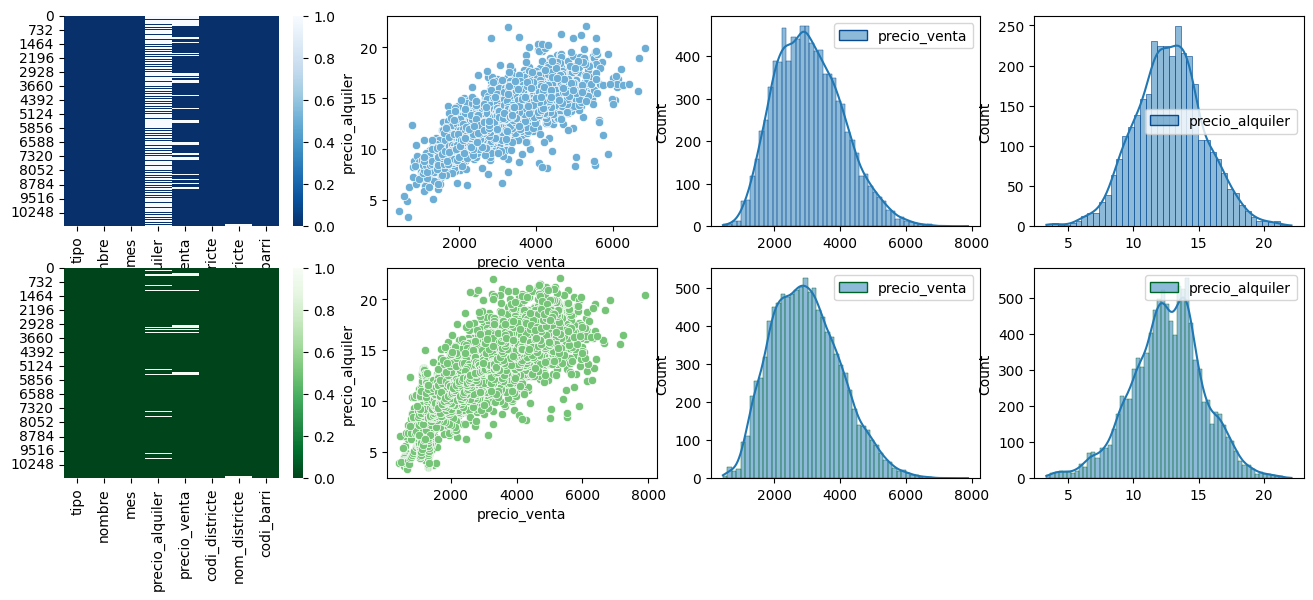

In [31]:
import matplotlib.cm as cm

def plot_data_dist(dfs):

    cmaps = ['Blues_r', 'Greens_r', 'Oranges_r', 'Reds_r', 'YlOrBr', 'YlOrRd', 'OrRd', 'PuRd', 'RdPu', 'BuPu', 'GnBu', 'PuBu', 'PuBuGn', 'PuRd', 'OrRd', 'YlGnBu', 'YlGn', 'YlOrBr', 'viridis', 'plasma', 'inferno', 'magma', 'cividis', 'Greys', 'Purples', 'YlOrRd']

    fig, axs = plt.subplots(len(dfs), 4, figsize=(16, 3*len(dfs)))
    # plt.grid(True)
    # Crear subplots
    for idx, df in enumerate(dfs):
        sns.heatmap(df.isnull(), annot=False, cmap=cmaps[idx], ax=axs[idx, 0] if len(dfs) > 1 else axs[0])
        sns.scatterplot(df, x='precio_venta', y='precio_alquiler', color=cm.get_cmap(cmaps[idx])(0.5), ax=axs[idx, 1] if len(dfs) > 1 else axs[1])
        sns.histplot(df[['precio_venta']], kde=True, color=cm.get_cmap(cmaps[idx])(0.5), edgecolor=cm.get_cmap(cmaps[idx])(0.1), ax=axs[idx, 2] if len(dfs) > 1 else axs[2])
        sns.histplot(df[['precio_alquiler']], kde=True, color=cm.get_cmap(cmaps[idx])(0.5), edgecolor=cm.get_cmap(cmaps[idx])(0.1), ax=axs[idx, 3] if len(dfs) > 1 else axs[3])
    plt.show()

plot_data_dist([bcn_precios, bcn_precios_int])

tipo  count
0      barri   9546
1  districte   1290
2   municipi    129

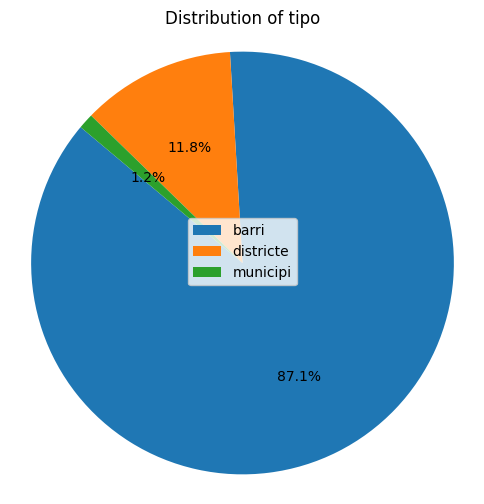

nom_districte  count
0           nou barris   1806
1       horta guinardo   1548
2           sant marti   1419
3       sants montjuic   1290
4          sant andreu   1032
5             eixample    903
6  sarria sant gervasi    903
7               gracia    774
8         ciutat vella    645
9            les corts    516

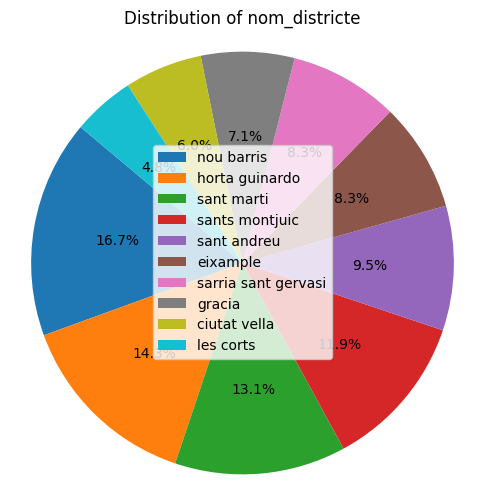

In [32]:
for c in ['tipo', 'nom_districte']:
    reason_counts = bcn_precios[c].value_counts()
    display(reason_counts.reset_index())
    # Create a pie plot using Seaborn for the 'status' column
    fig = plt.figure(figsize=(6,6))
    plt.title(f'Distribution of {c}')
    plt.pie(reason_counts, autopct='%1.1f%%', startangle=140)
    plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    fig.legend(loc='center', labels=reason_counts.index)
    plt.show()

Gráfico de dispersión de precio_alquiler vs precio_venta


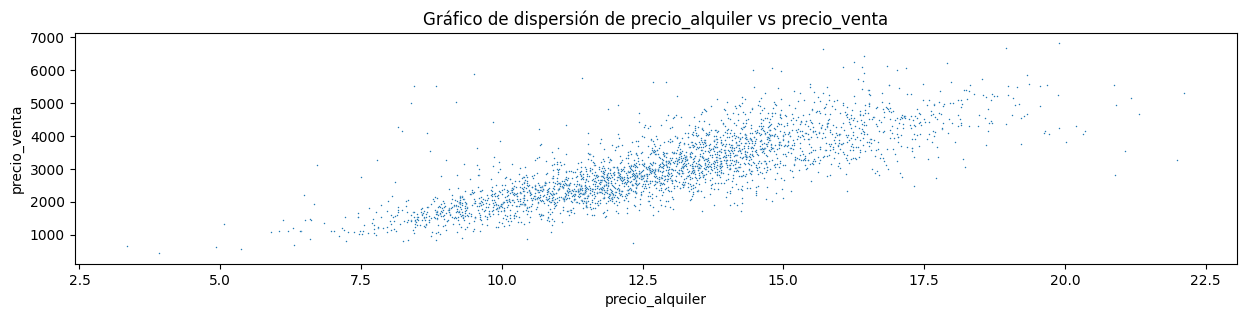

Gráfico de dispersión de precio_alquiler vs codi_districte


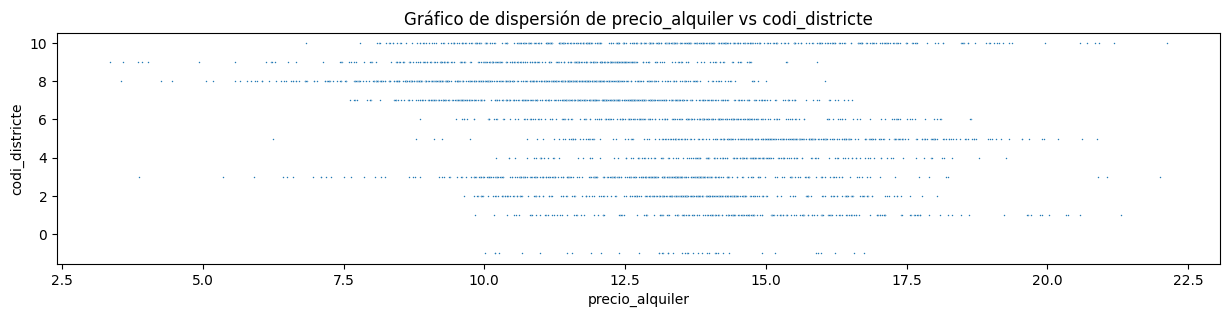

Gráfico de dispersión de precio_alquiler vs codi_barri


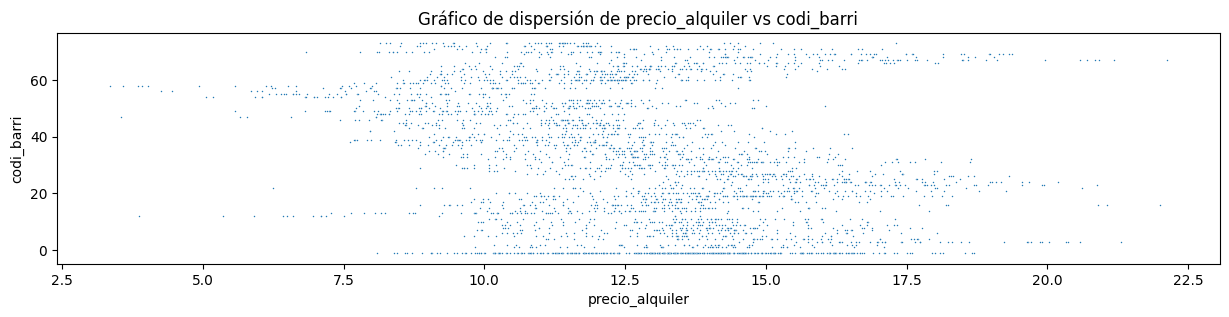

Gráfico de dispersión de precio_venta vs codi_districte


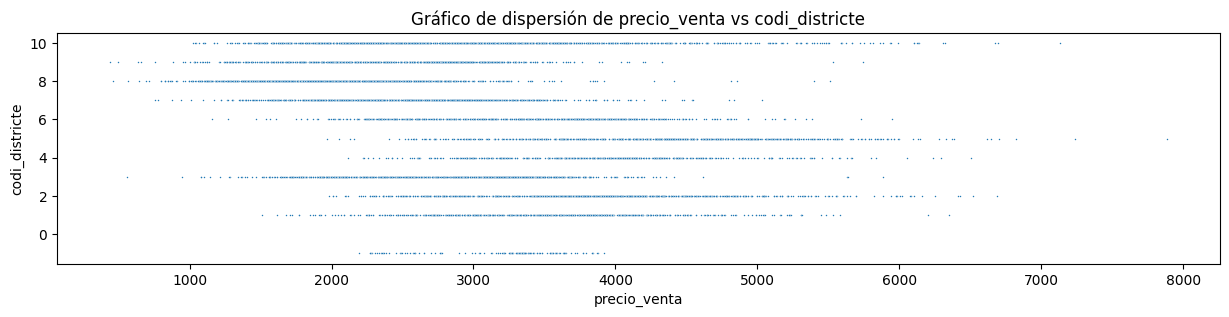

Gráfico de dispersión de precio_venta vs codi_barri


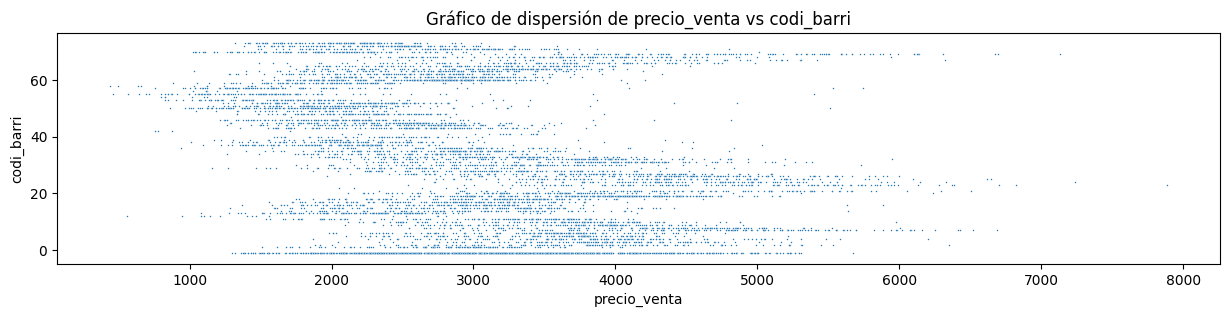

Gráfico de dispersión de codi_districte vs codi_barri


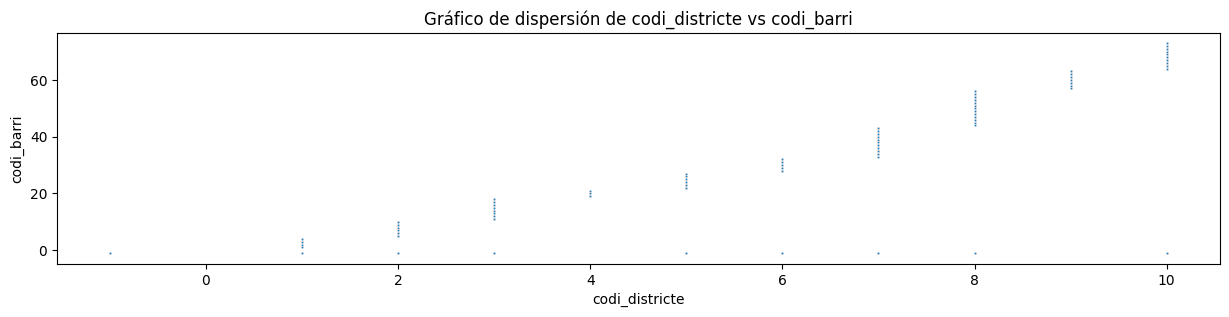

In [38]:
import itertools

# Genera gráficos de dispersión para todas las combinaciones de columnas numéricas

columnas_numericas=bcn_precios.describe().columns.tolist()

for c1, c2 in itertools.combinations(columnas_numericas, 2):
    print(f'Gráfico de dispersión de {c1} vs {c2}')
    plt.figure(figsize=(15, 3))
    plt.title(f'Gráfico de dispersión de {c1} vs {c2}')
    if bcn_precios[c1].dtype.kind != 'M' and bcn_precios[c2].dtype.kind == 'M':
        t = c1
        c1 = c2
        c2 = t
    sns.scatterplot(data=bcn_precios, x=c1, y=c2, marker='.', s=5)
    # if bcn_precios[c1].dtype.kind != 'M' and bcn_precios[c2].dtype.kind != 'M':
    #     z = np.polyfit(bcn_precios[c1].dropna(subset=[c1,c2]), bcn_precios[c2].dropna(subset=[c1,c2]), 1)
    #     p = np.poly1d(z)
    #     plt.plot(bcn_precios[c1],p(bcn_precios[c1]),"r--")
    #     # plt.hexbin(bcn_precios=bcn_precios, x=c1, y=c2, gridsize=30, cmap='Blues')

    plt.show()

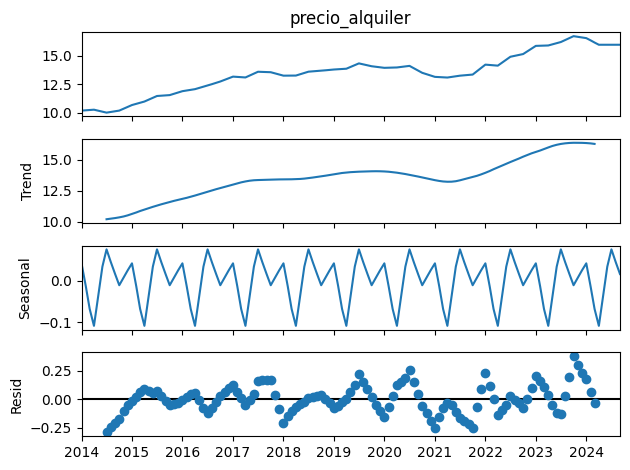

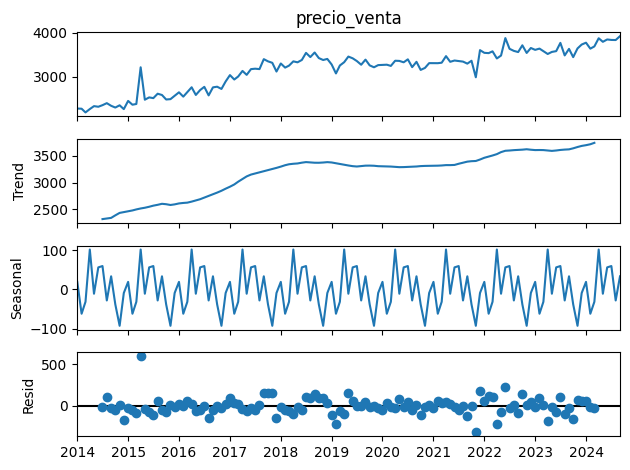

In [62]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Descomposición de series temporales para cada columna numérica individual
for c in ['precio_alquiler', 'precio_venta']:
    df = bcn_precios[bcn_precios['nombre'] == 'barcelona'].interpolate().set_index('mes')[c]
    seasonal_decompose(df).plot()

    plt.show()
 

## Análisis de cohotes

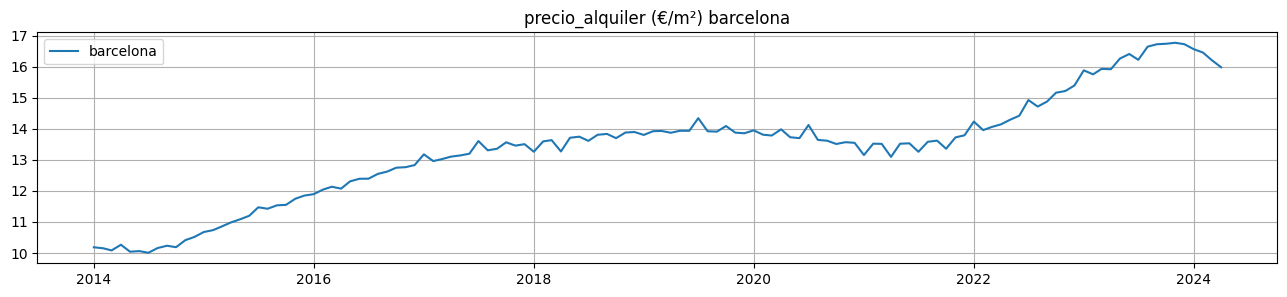

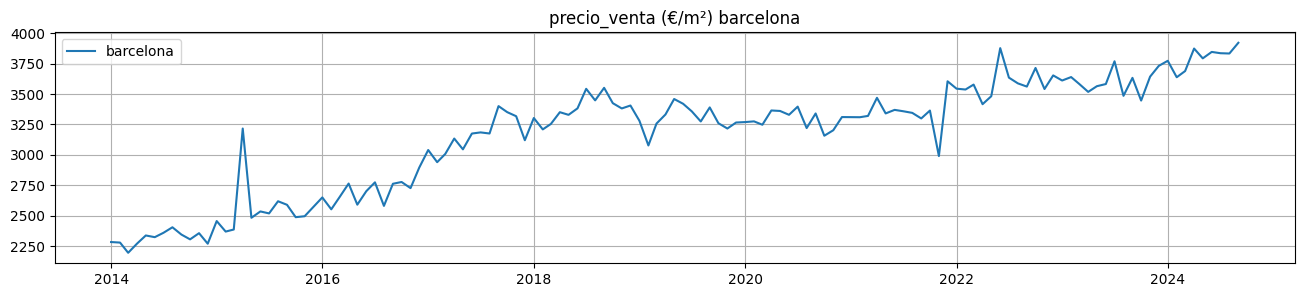

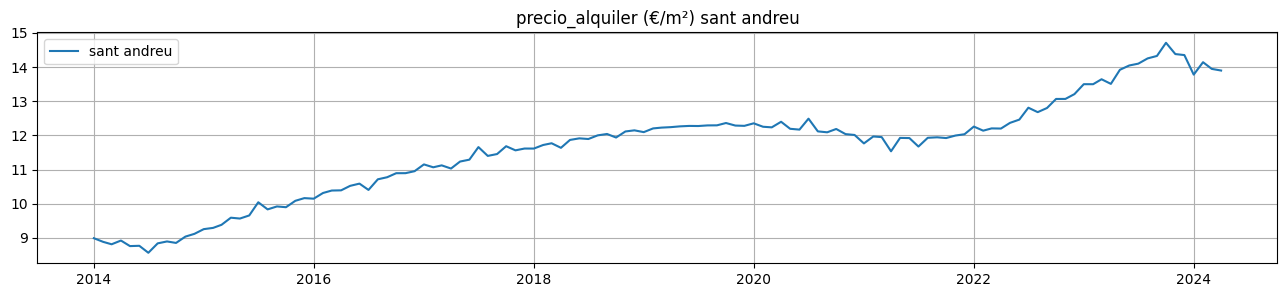

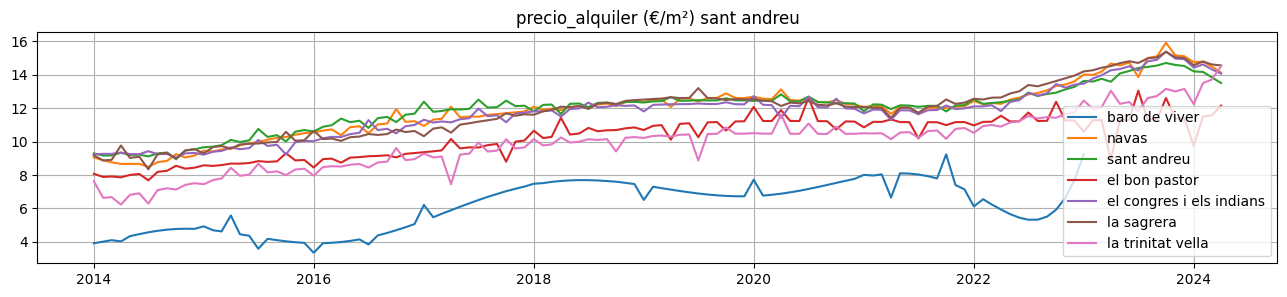

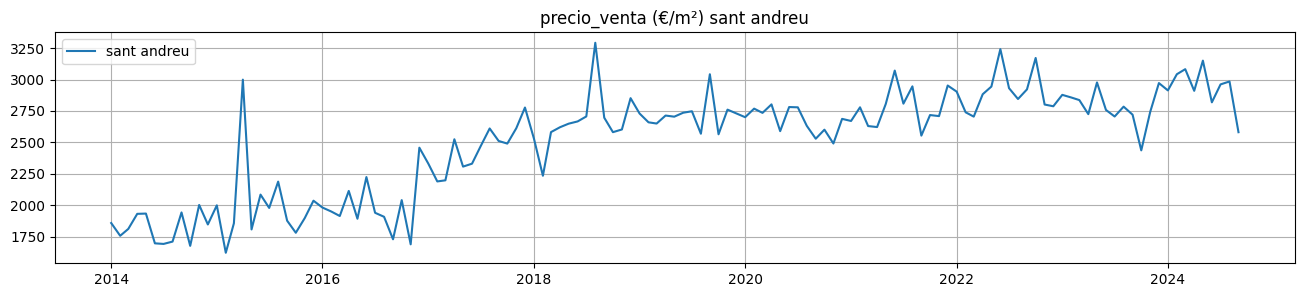

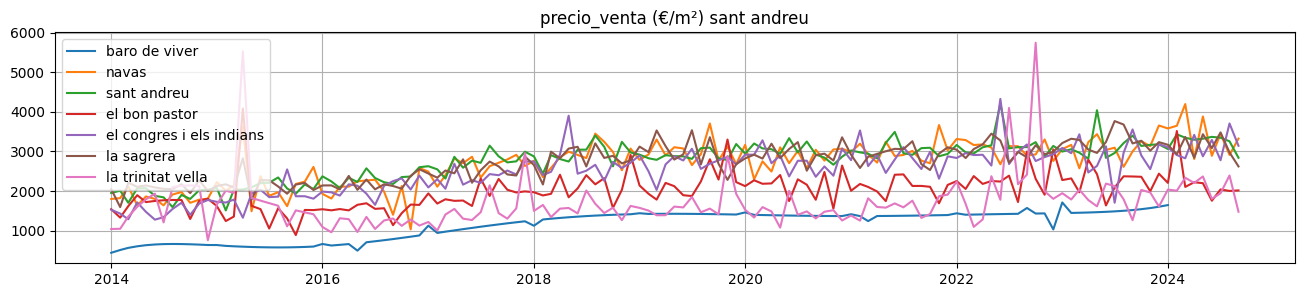

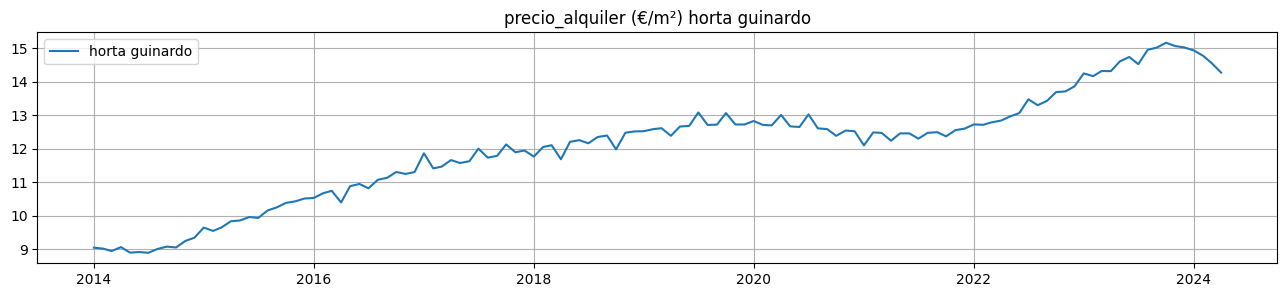

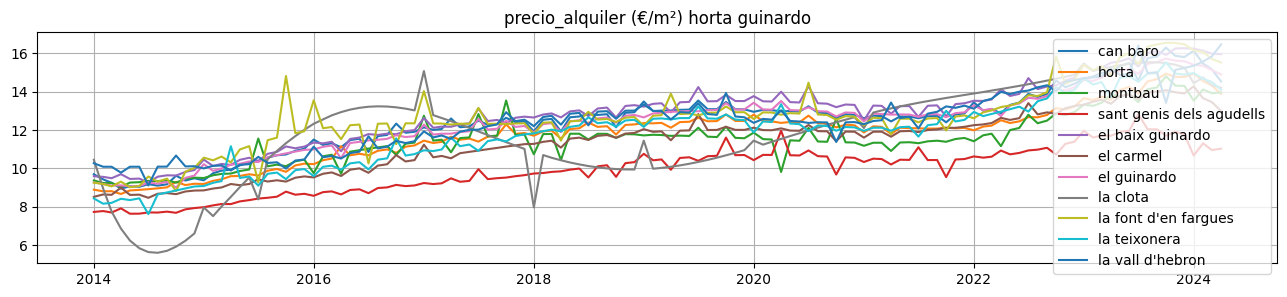

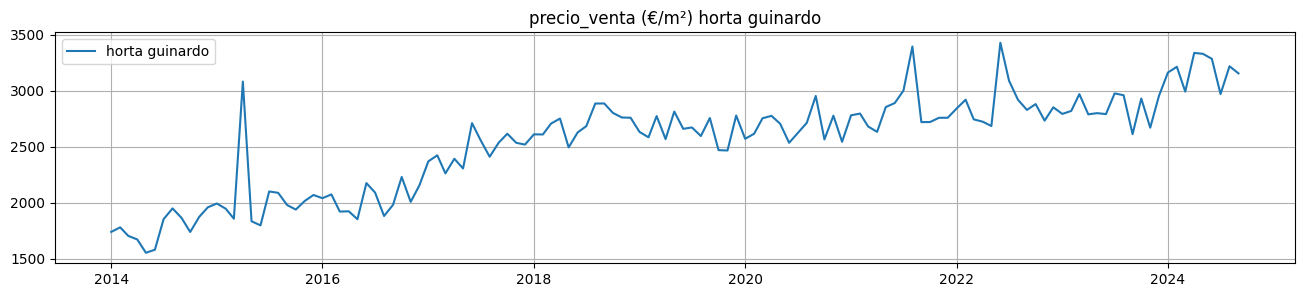

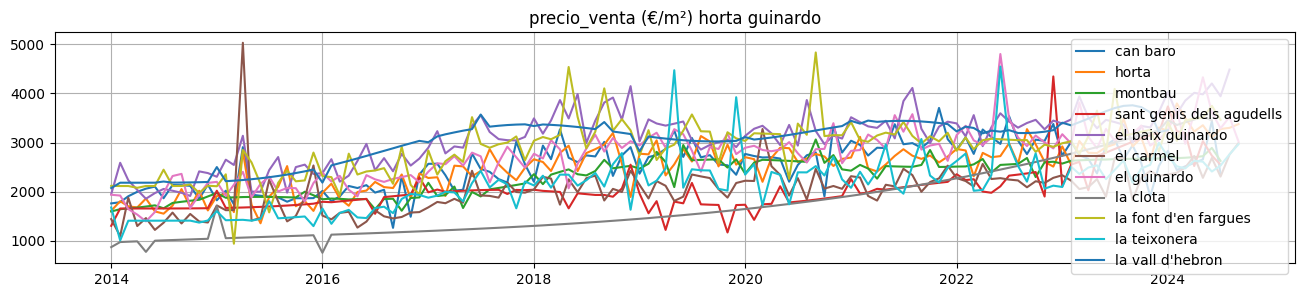

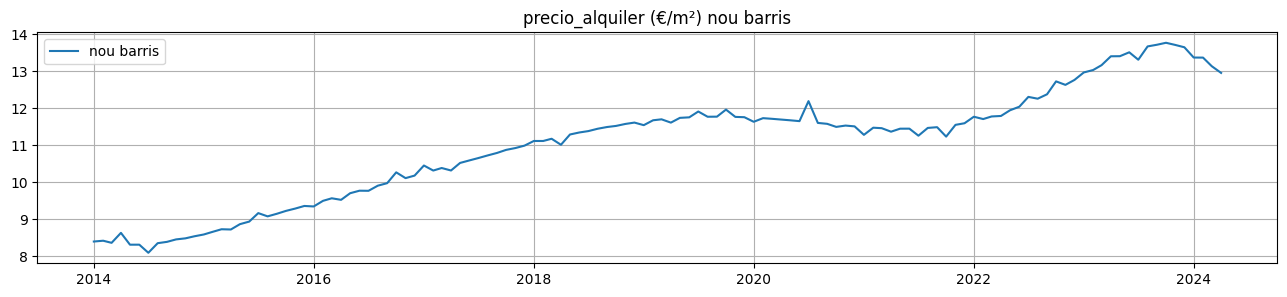

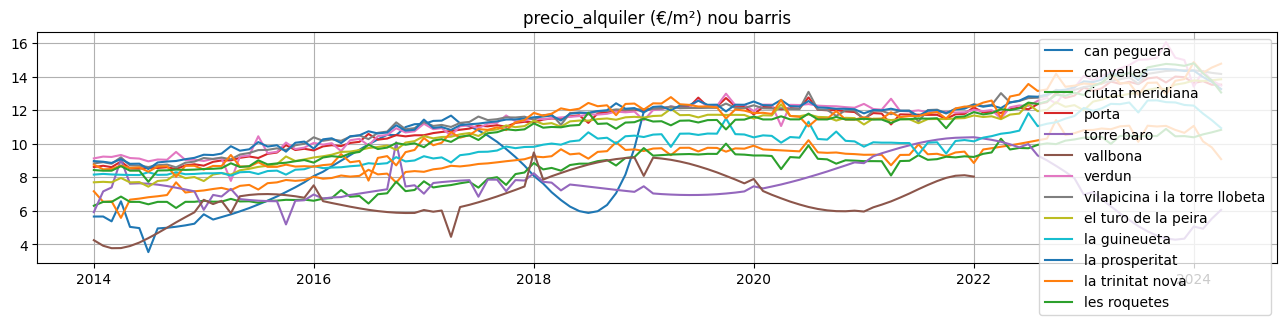

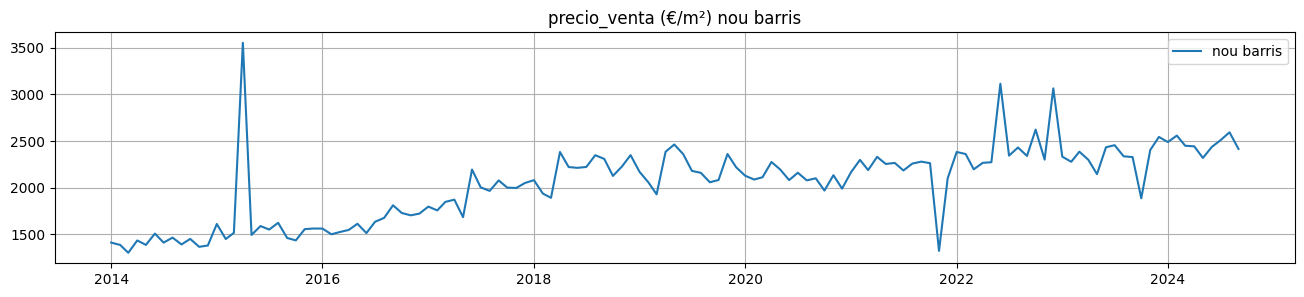

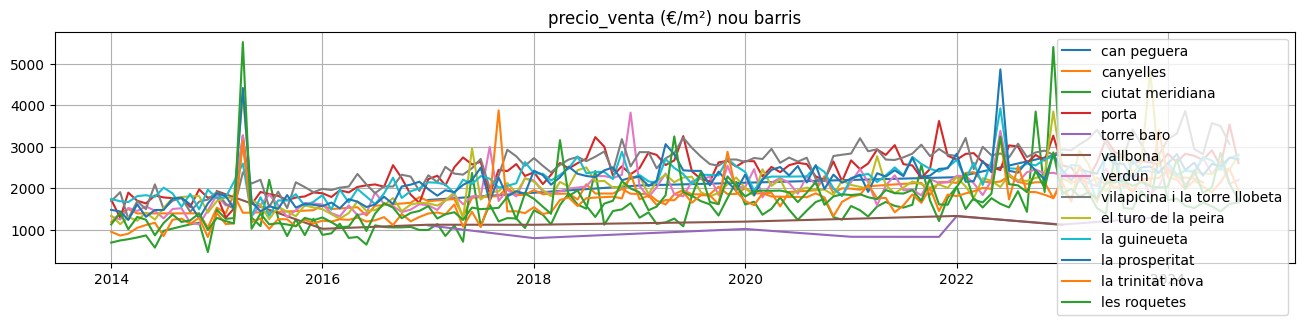

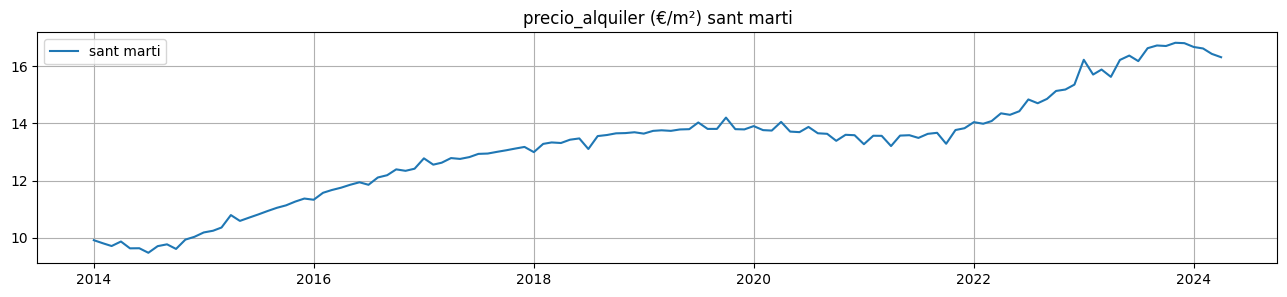

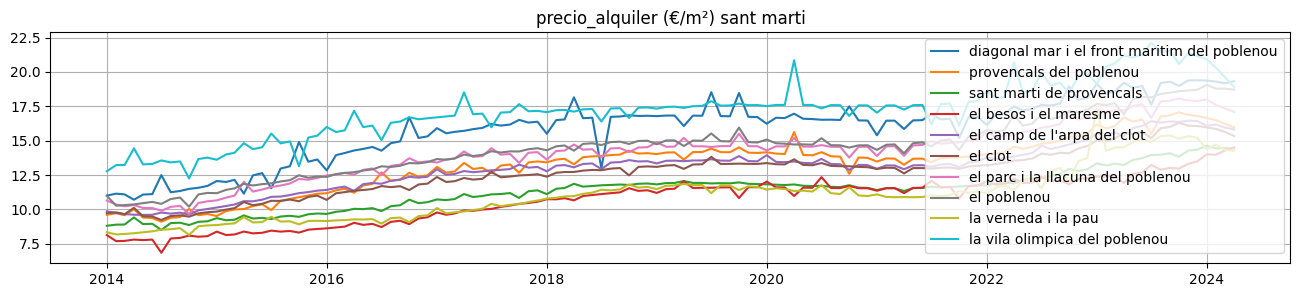

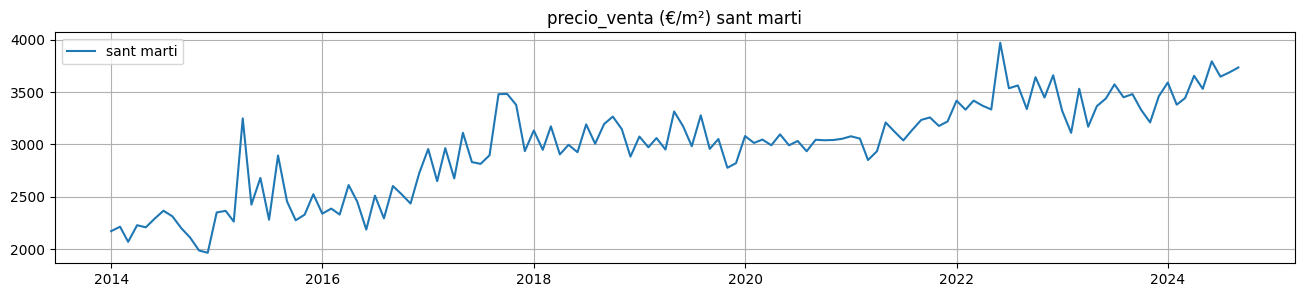

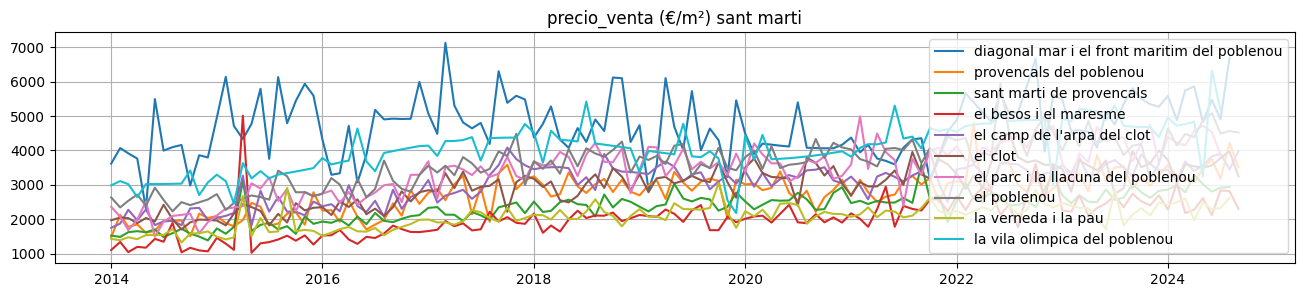

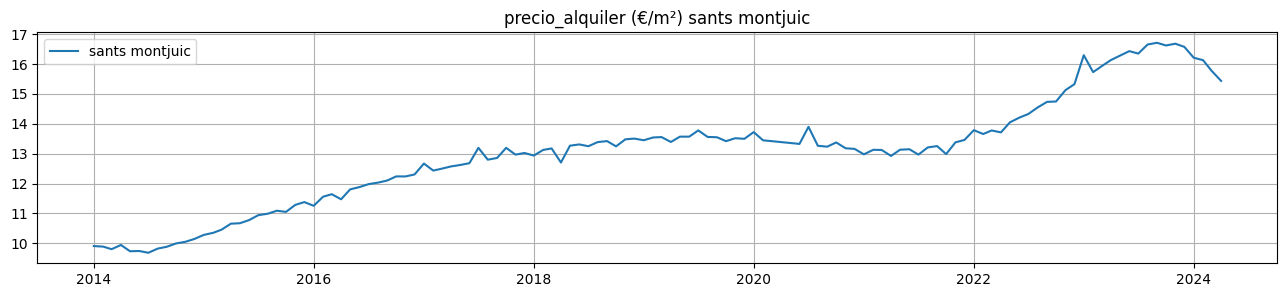

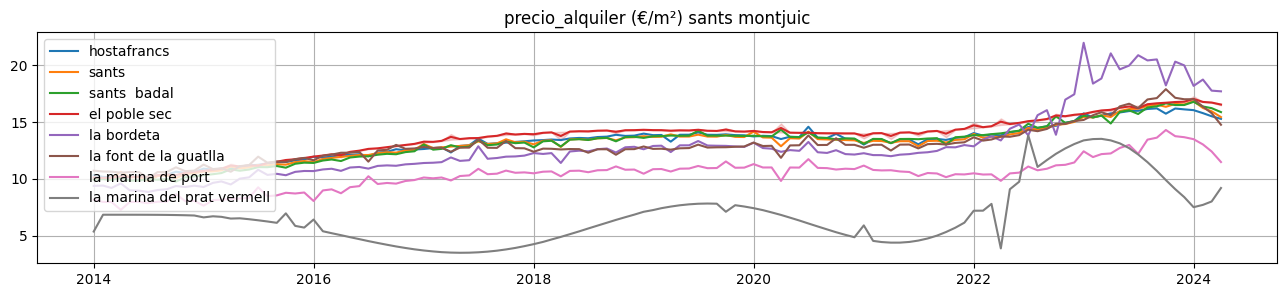

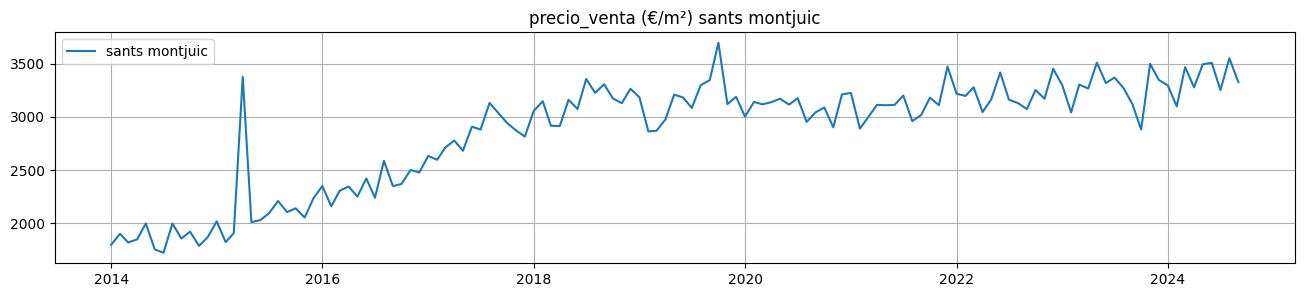

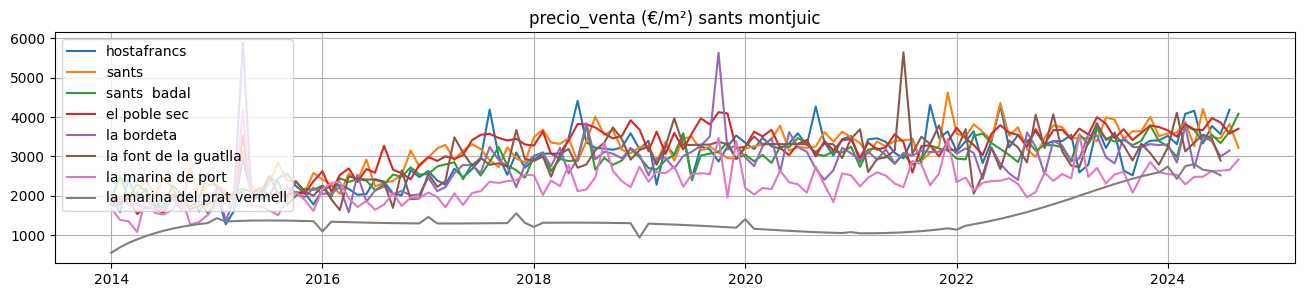

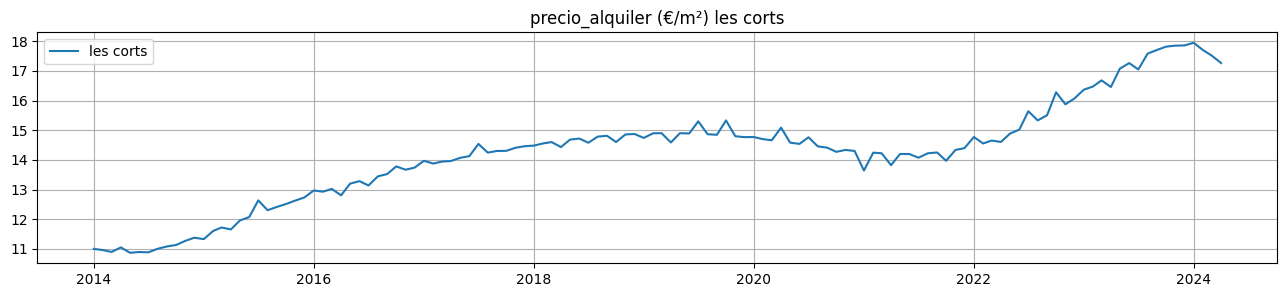

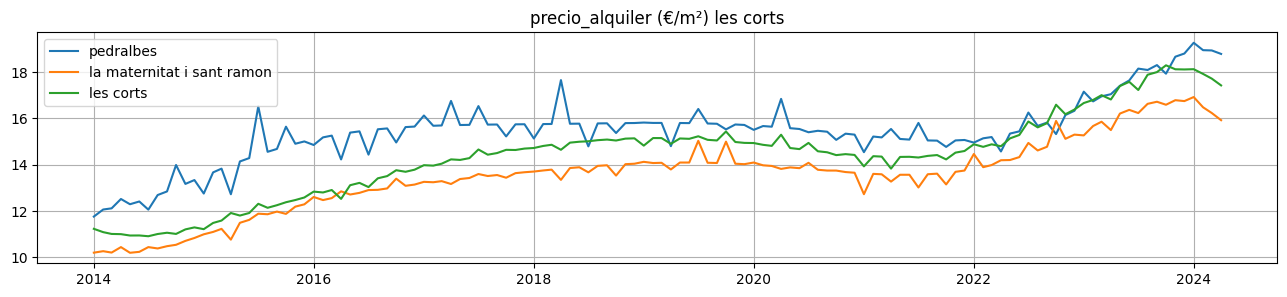

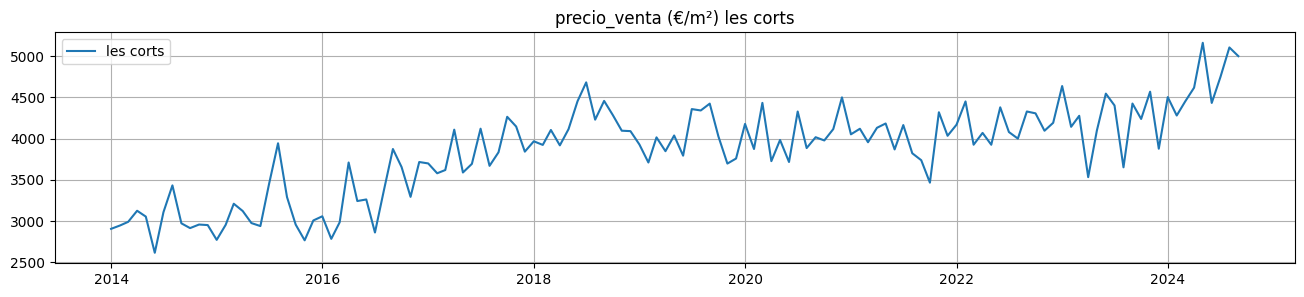

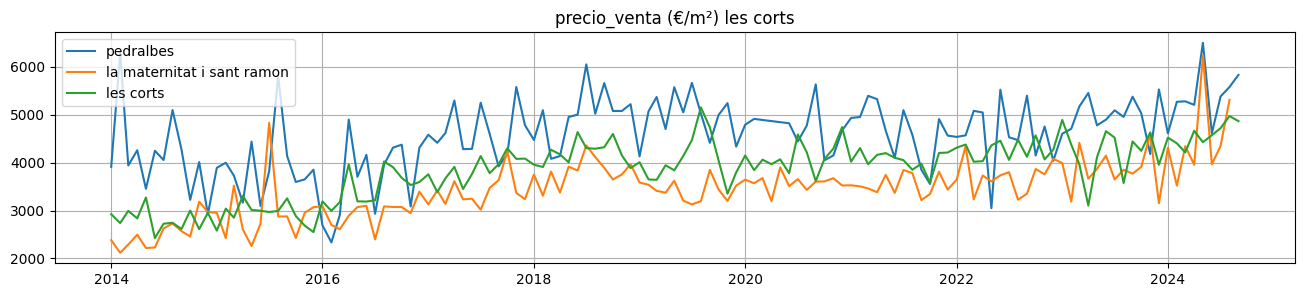

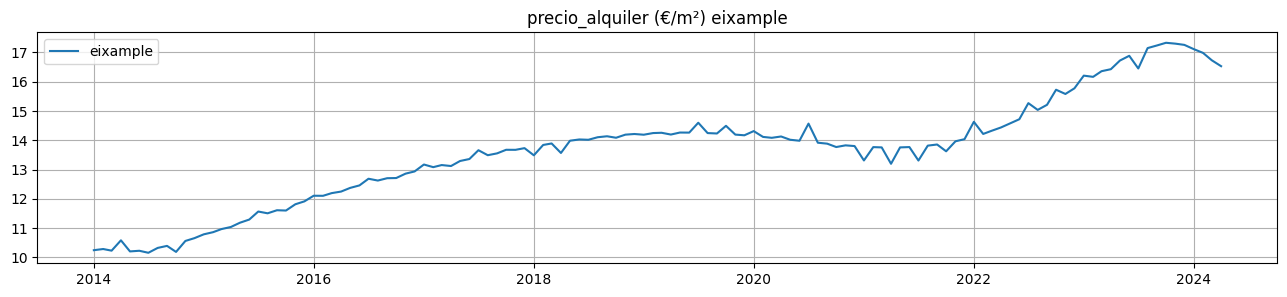

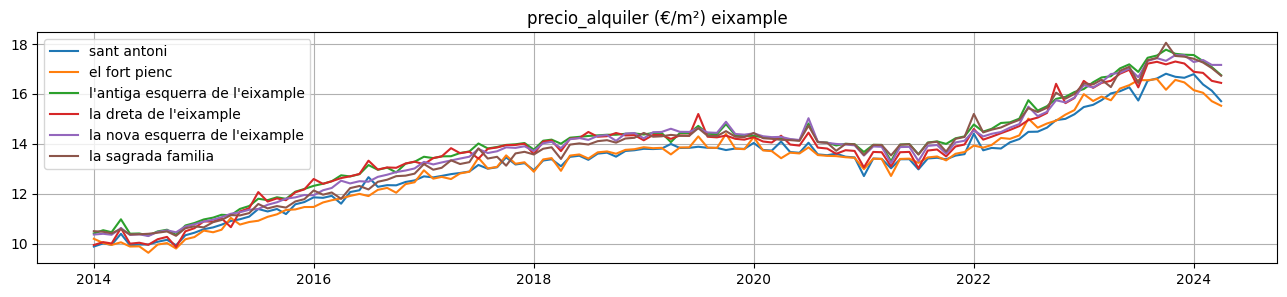

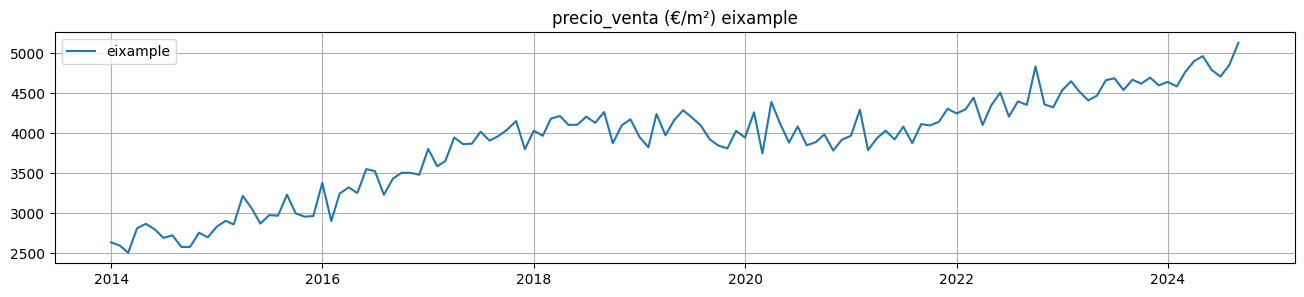

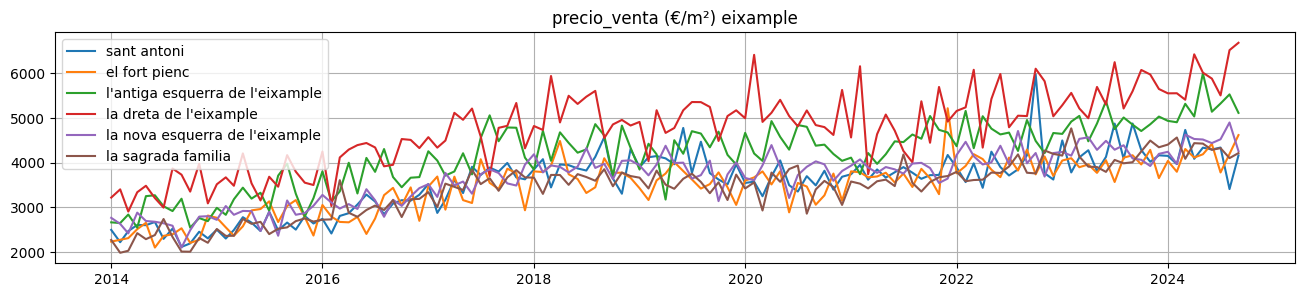

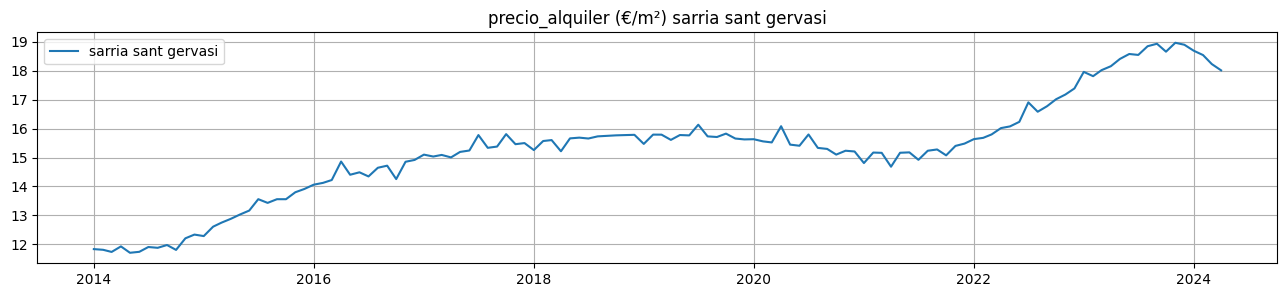

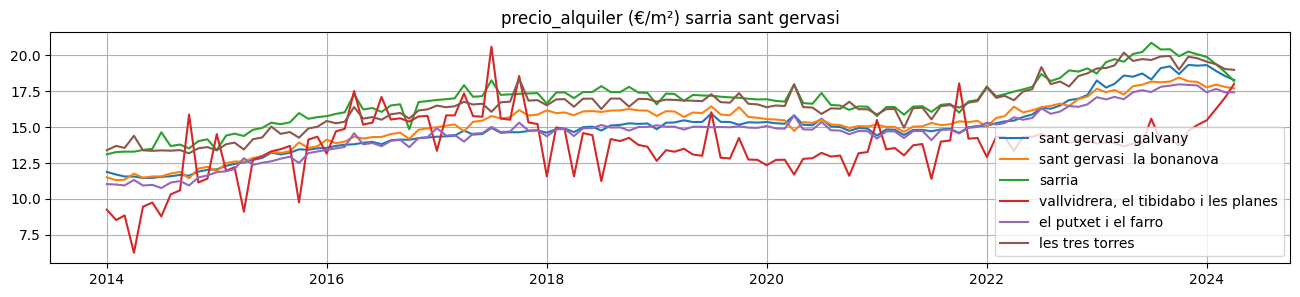

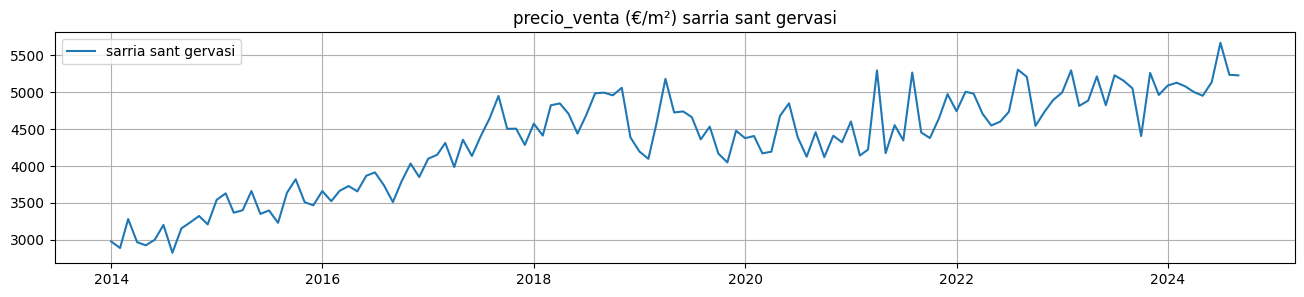

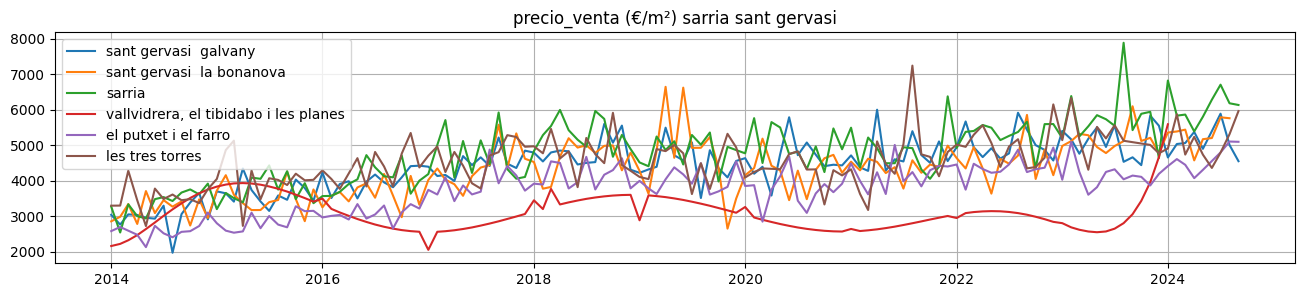

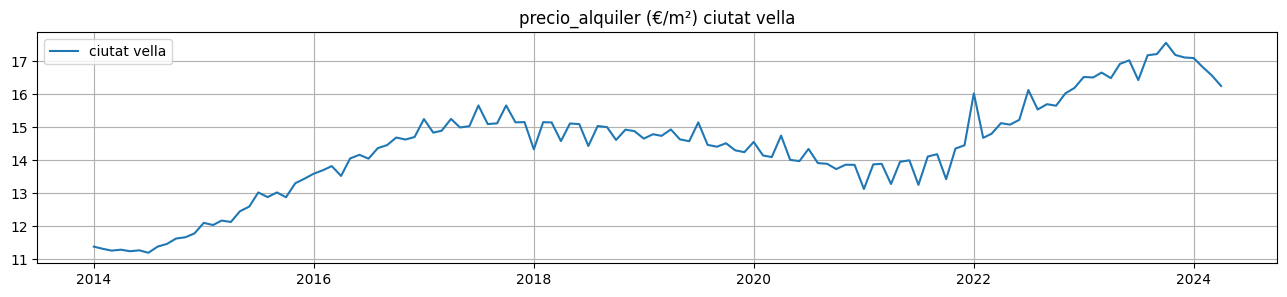

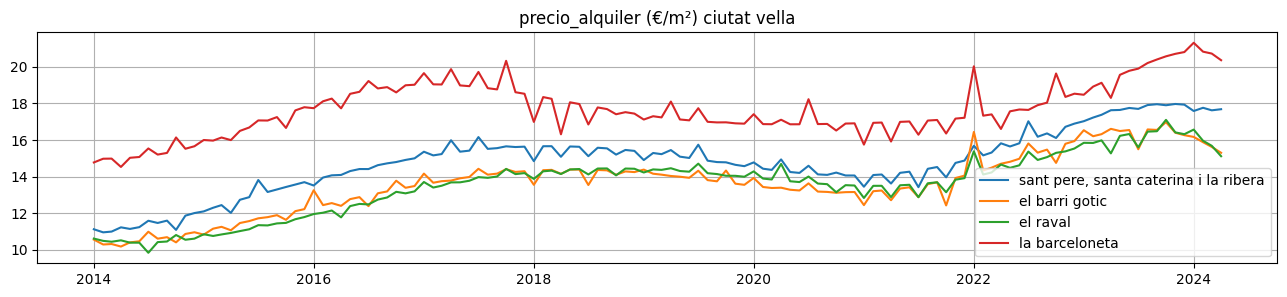

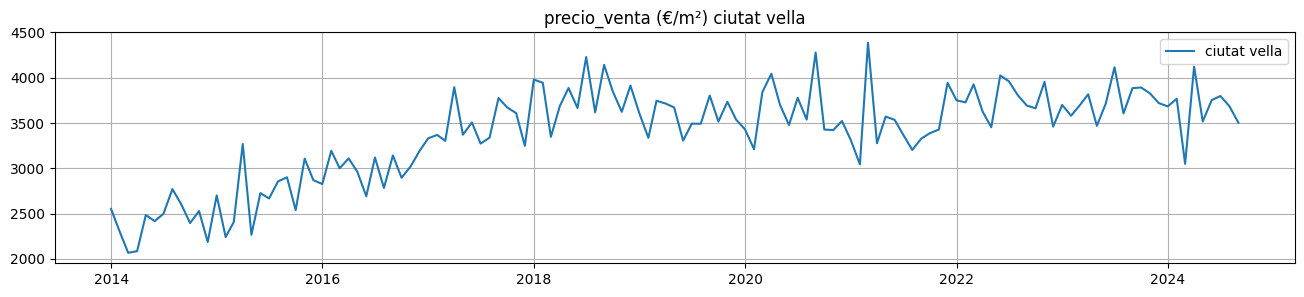

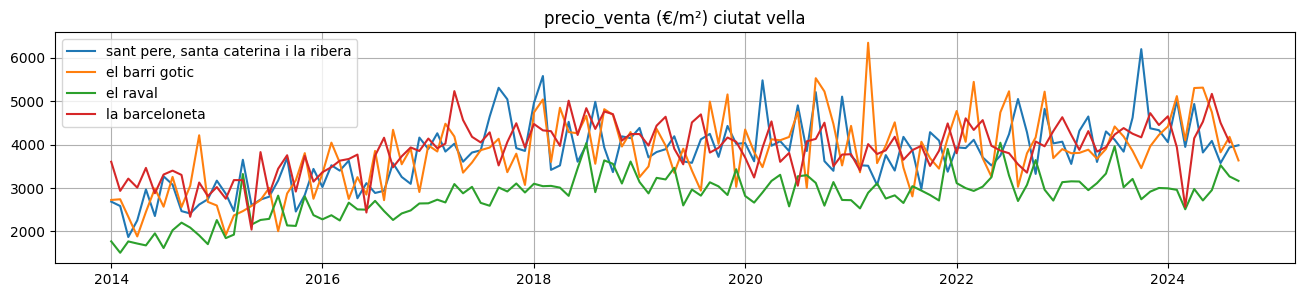

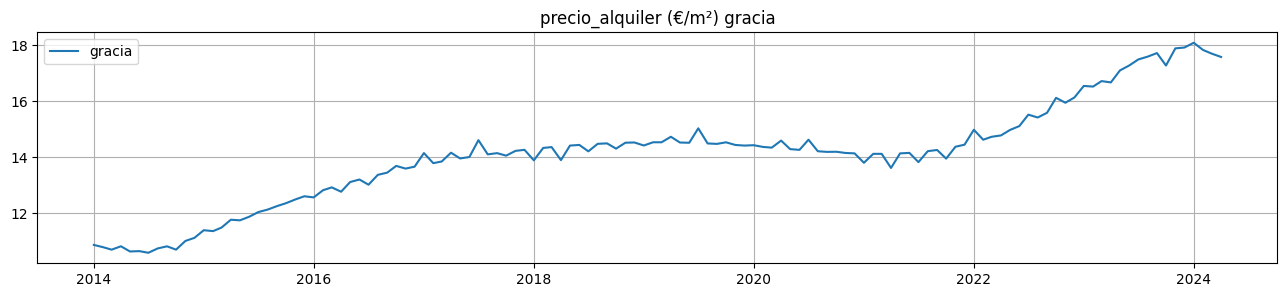

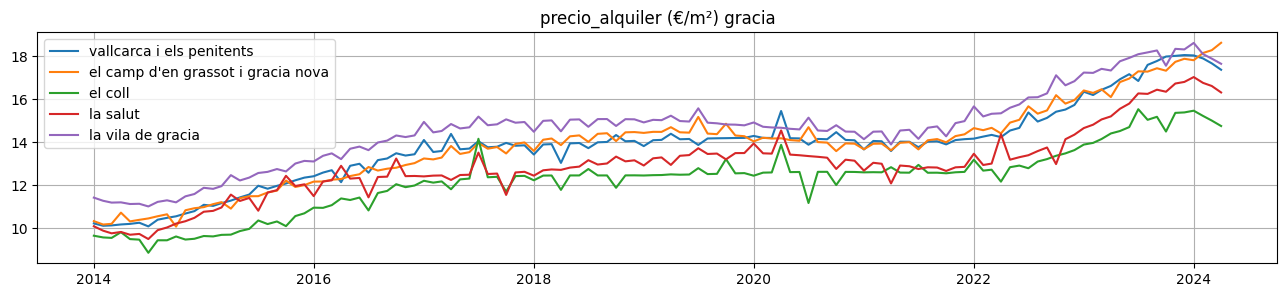

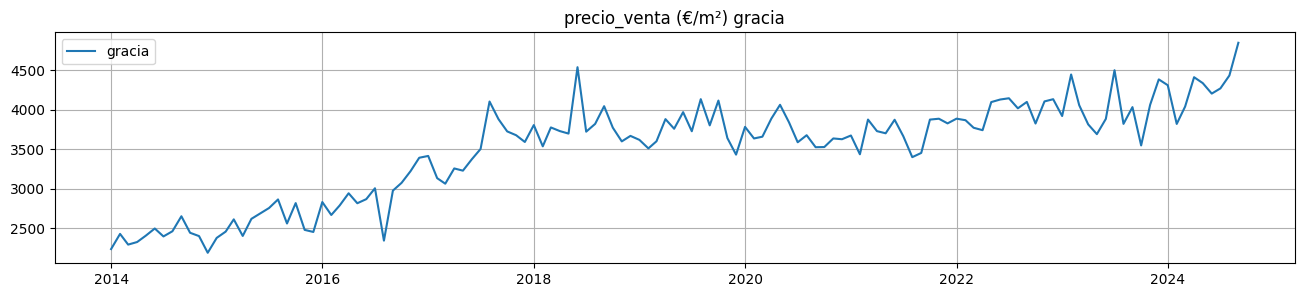

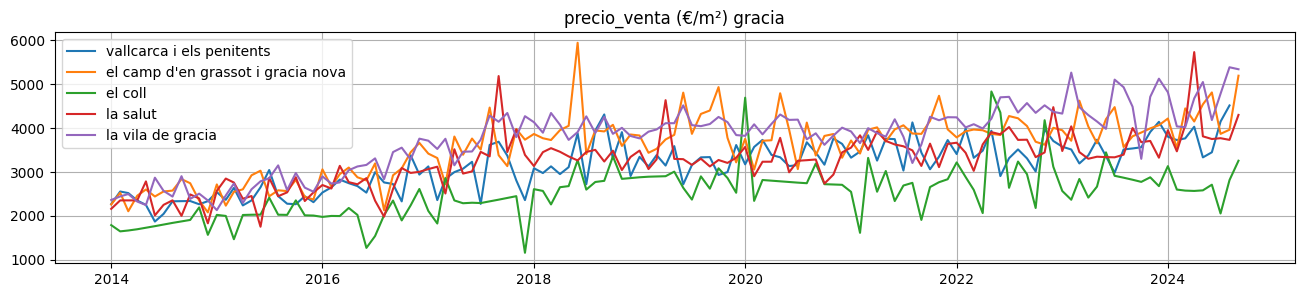

In [ ]:
def plot_dist(df, field, figsize=(16, 4), title='', model=None):
    fig = plt.figure(figsize=figsize)
    for c in df['nombre'].unique():
        # sns.scatterplot(x='mes', y=field, data=df[df['nombre'] == c], markers='.')
        sns.lineplot(x='mes', y=field, data=df[df['nombre'] == c], label=c)
        plt.title(f'{field} (€/m²) '+title)
    plt.grid(True)
    plt.xlabel('')
    plt.ylabel('')
    plt.show()


plot_dist(bcn_precios_int[bcn_precios_int['nombre'] == 'barcelona'], 'precio_alquiler',figsize=(16,3), title='barcelona')
plot_dist(bcn_precios_int[bcn_precios_int['nombre'] == 'barcelona'], 'precio_venta',figsize=(16,3), title='barcelona')


for dist in bcn_precios_int['nom_districte'].dropna().unique().tolist():
    plot_dist(bcn_precios_int[(bcn_precios_int['nom_districte'] == dist) & (bcn_precios_int['tipo'] == 'districte')], 'precio_alquiler',figsize=(16,3), title=dist)
    plot_dist(bcn_precios_int[(bcn_precios_int['nom_districte'] == dist) & (bcn_precios_int['tipo'] == 'barri')], 'precio_alquiler',figsize=(16,3), title=dist)
    plot_dist(bcn_precios_int[(bcn_precios_int['nom_districte'] == dist) & (bcn_precios_int['tipo'] == 'districte')], 'precio_venta',figsize=(16,3), title=dist)
    plot_dist(bcn_precios_int[(bcn_precios_int['nom_districte'] == dist) & (bcn_precios_int['tipo'] == 'barri')], 'precio_venta',figsize=(16,3), title=dist)

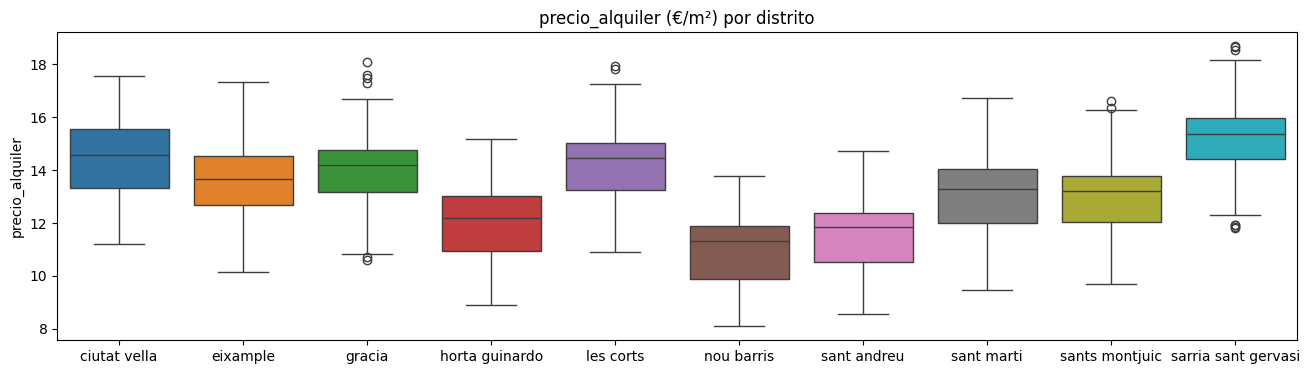

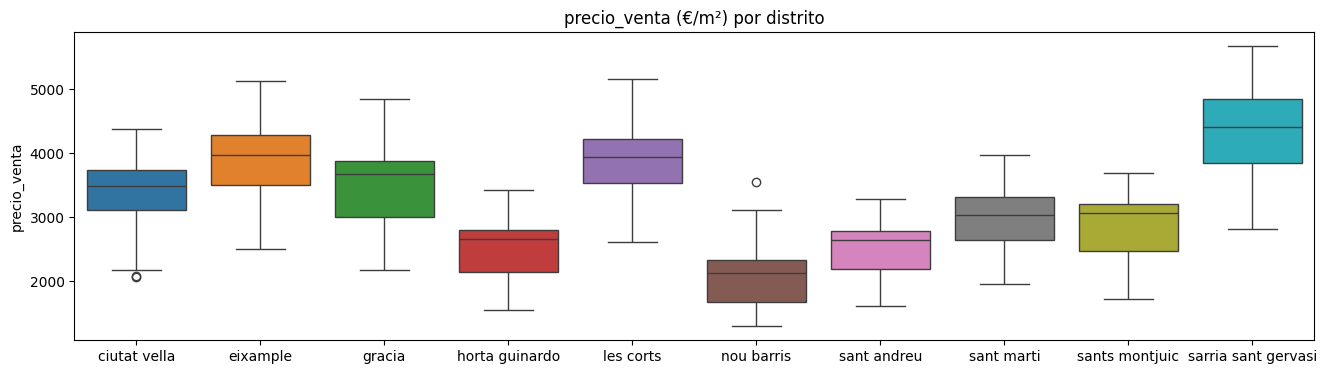

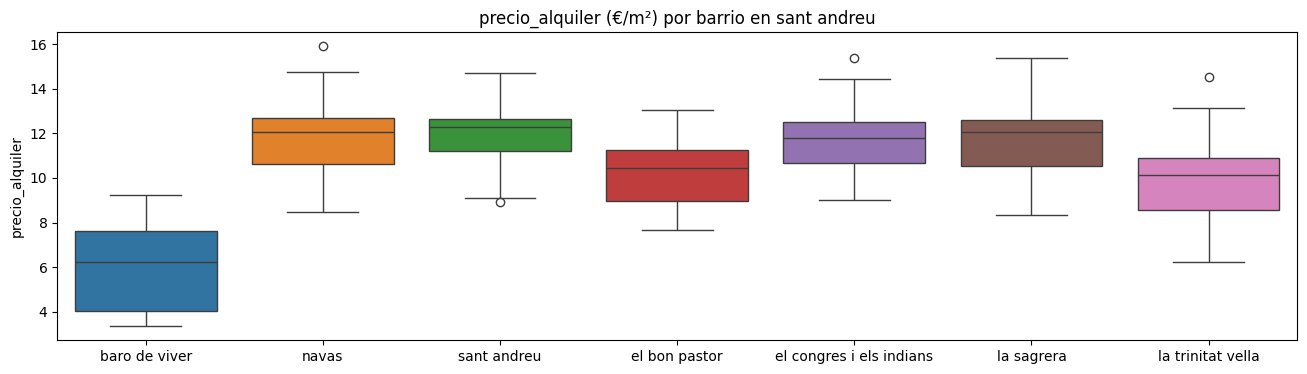

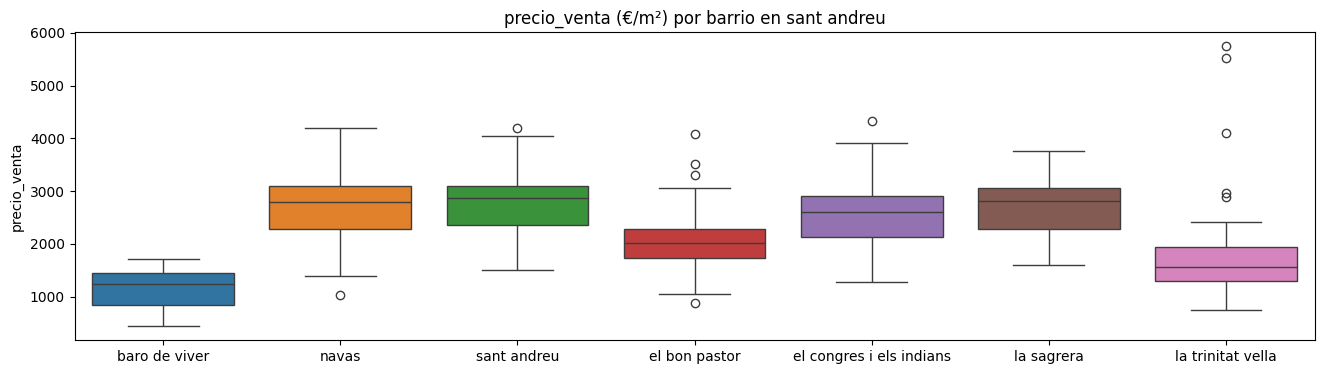

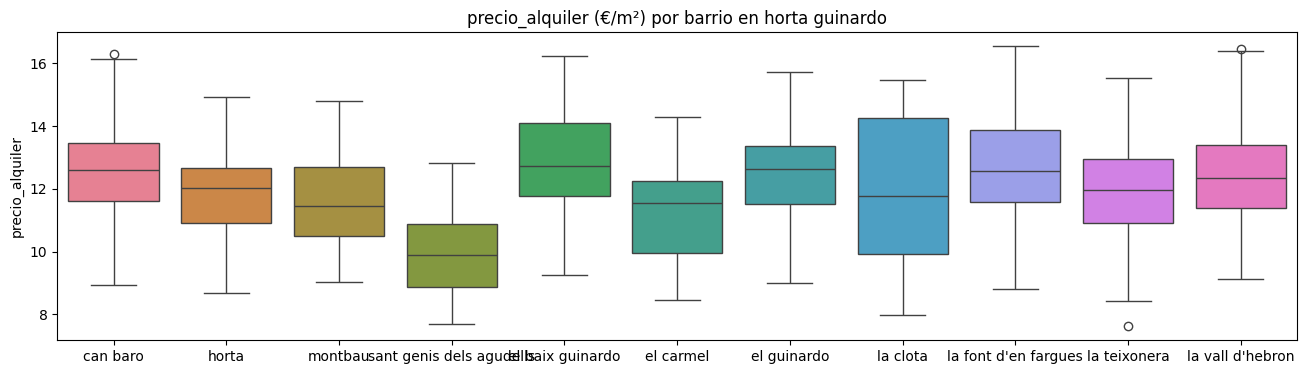

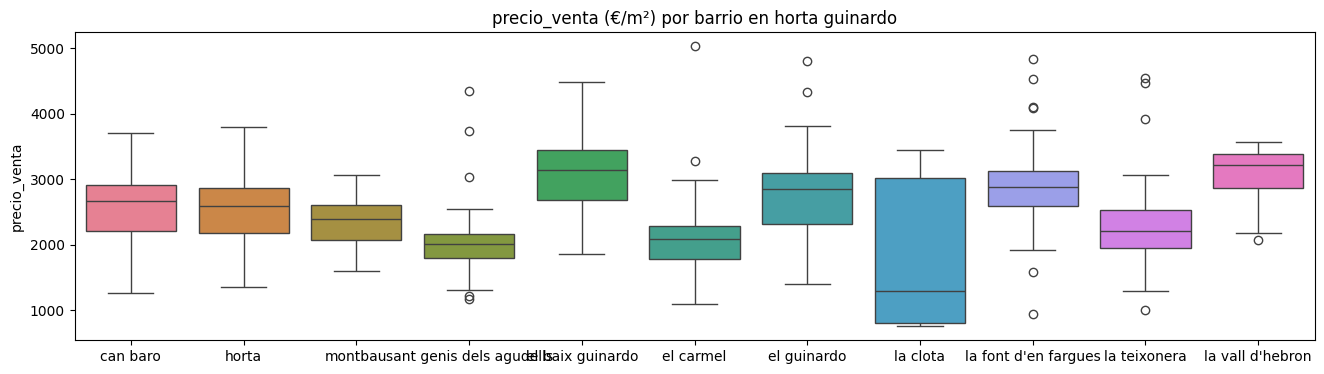

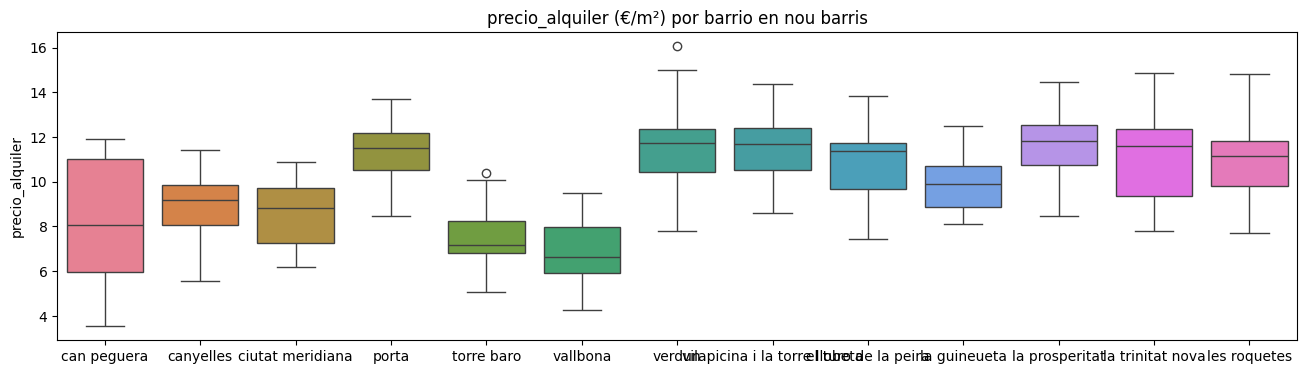

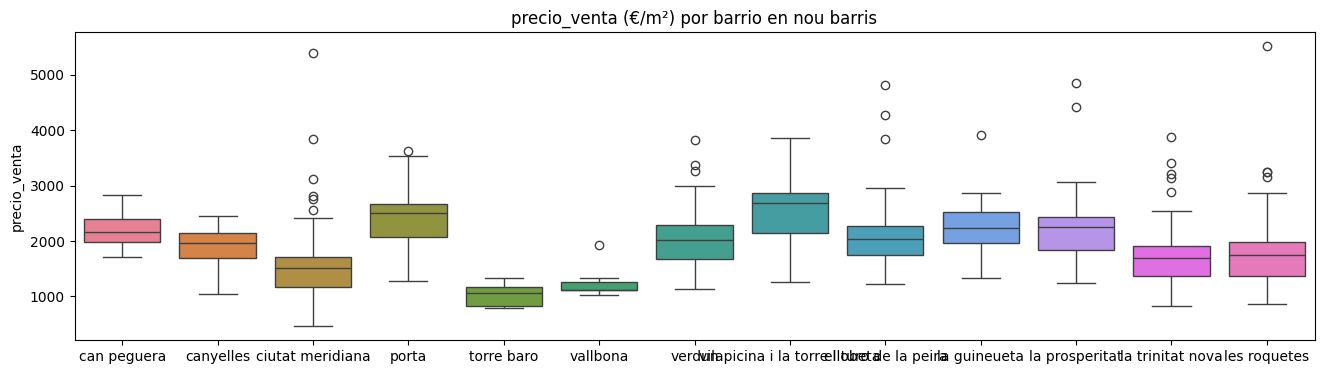

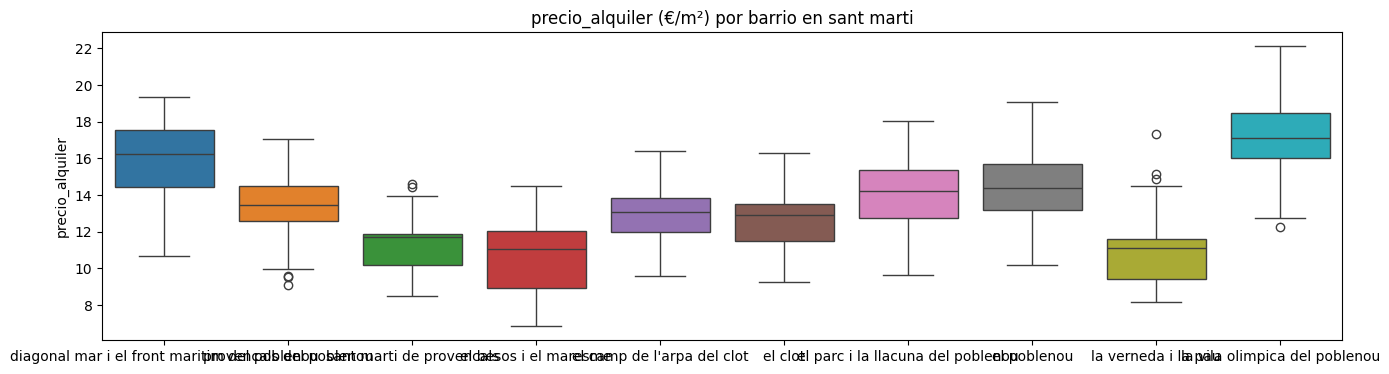

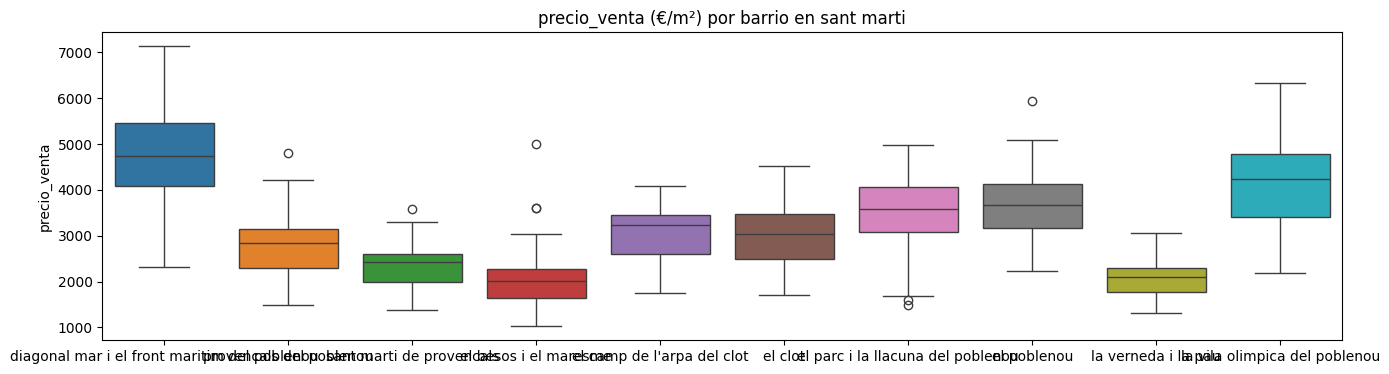

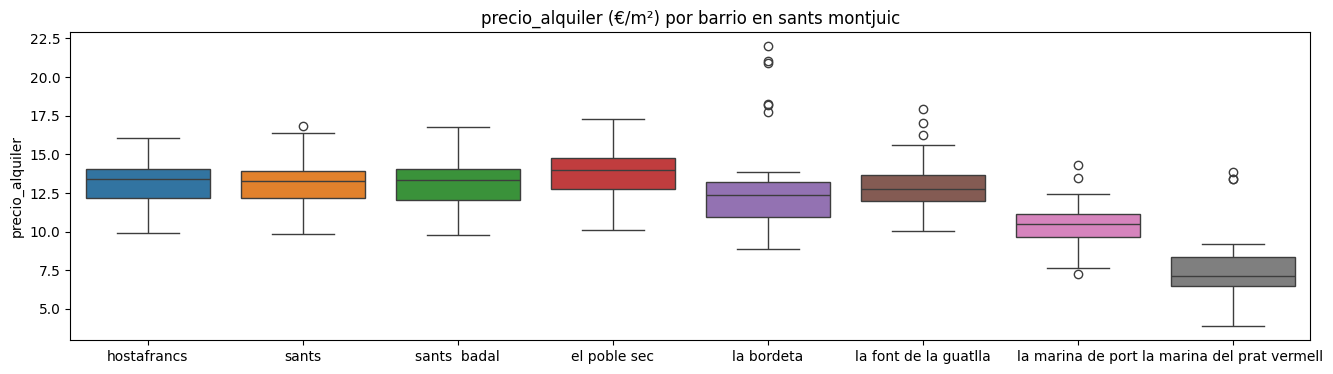

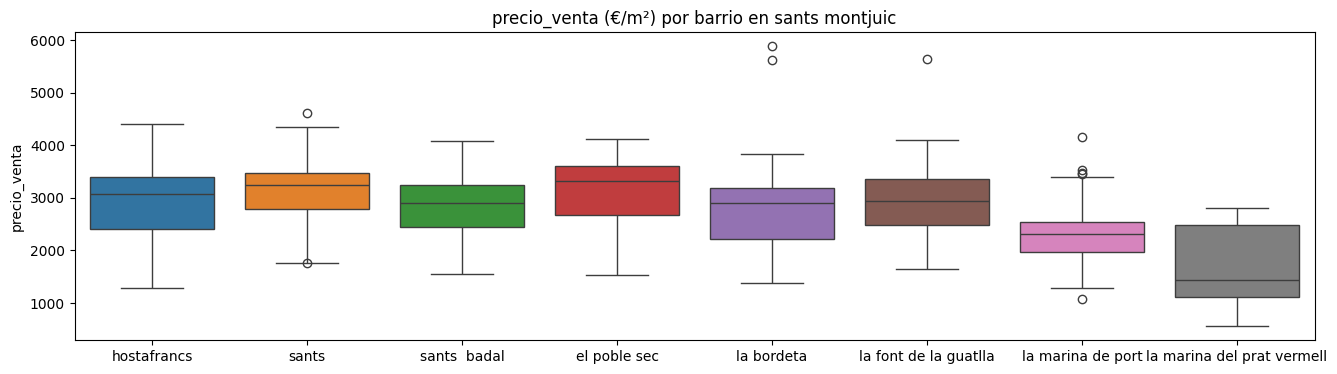

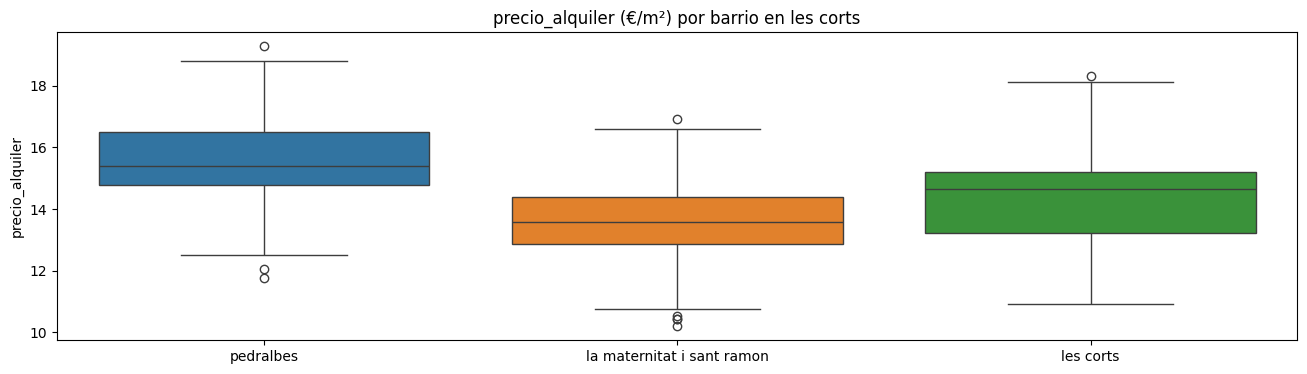

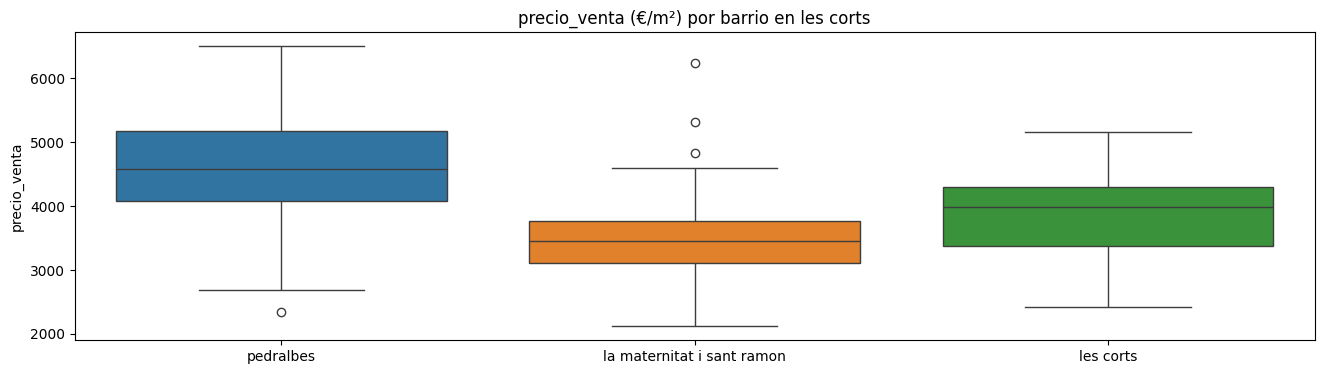

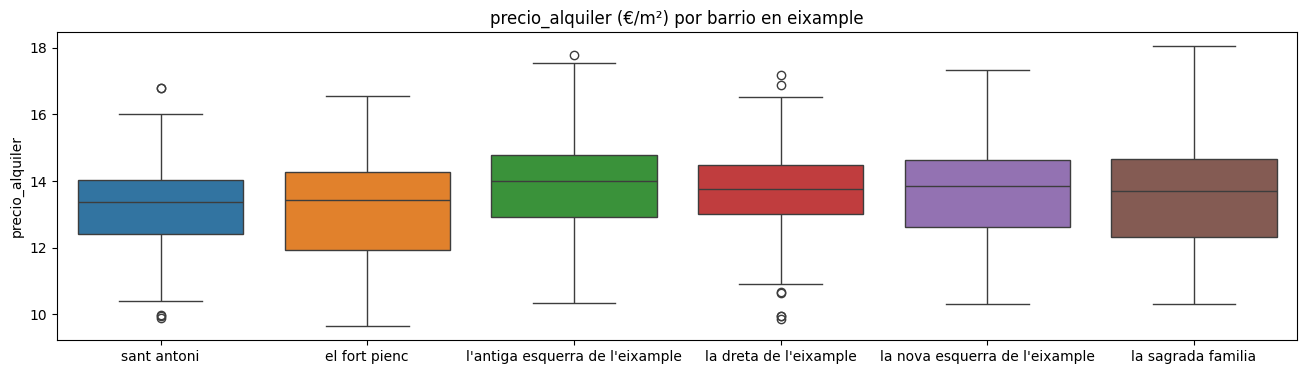

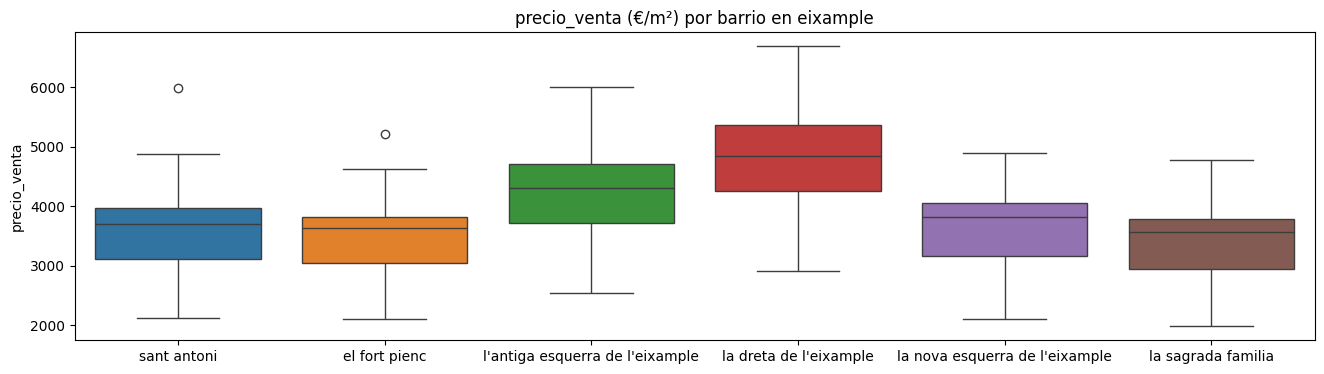

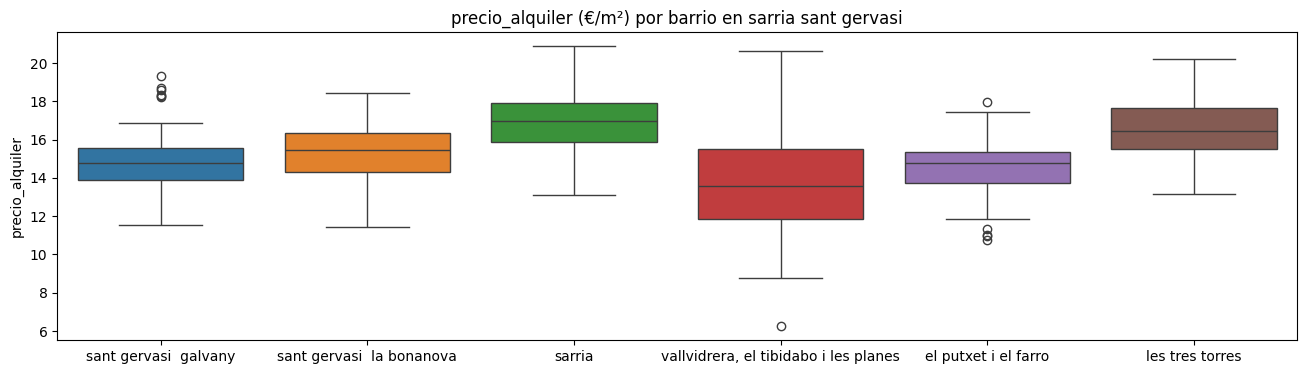

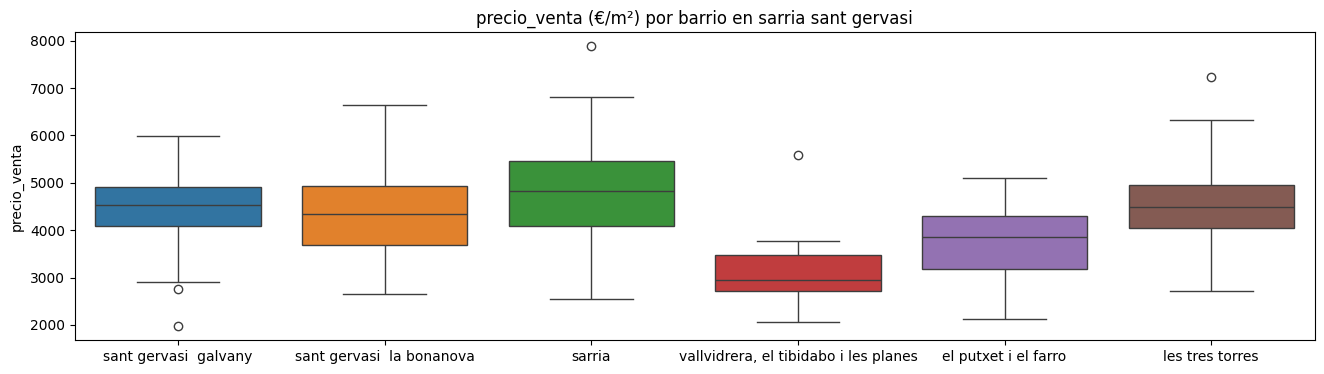

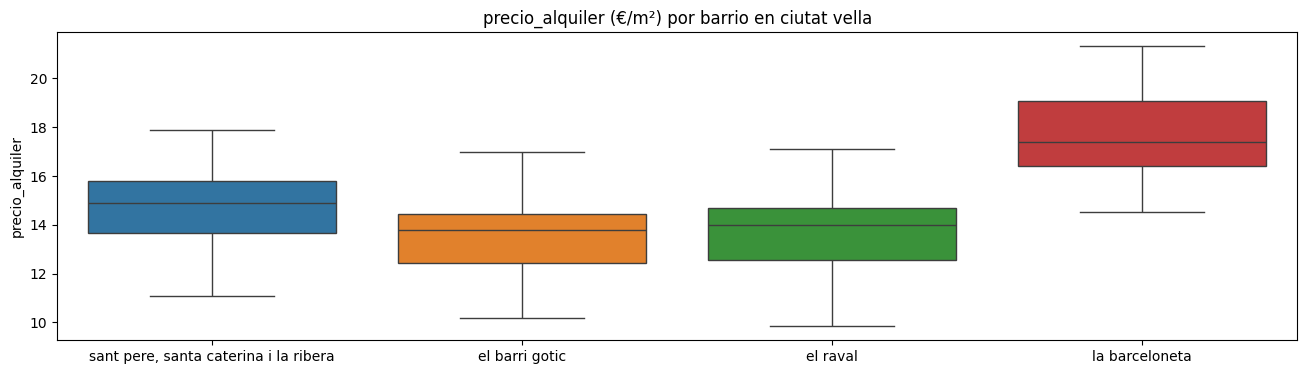

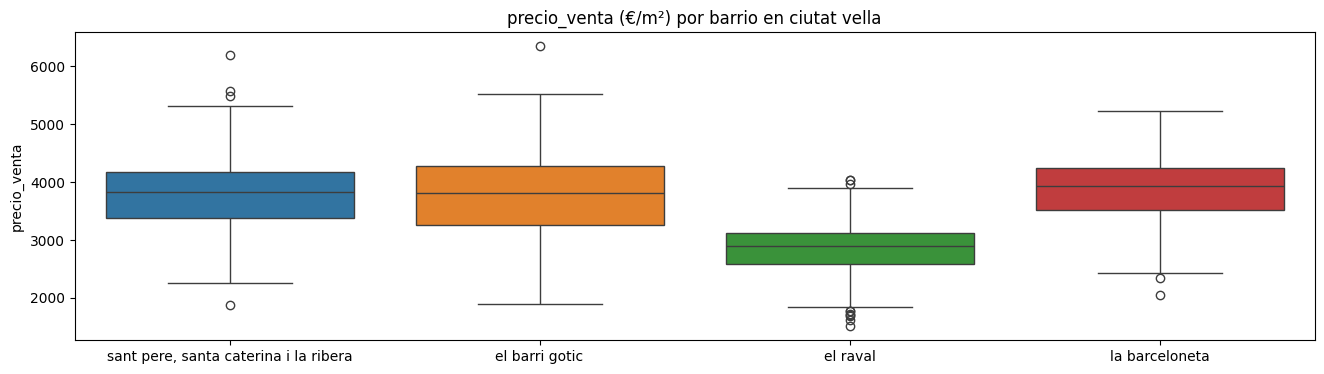

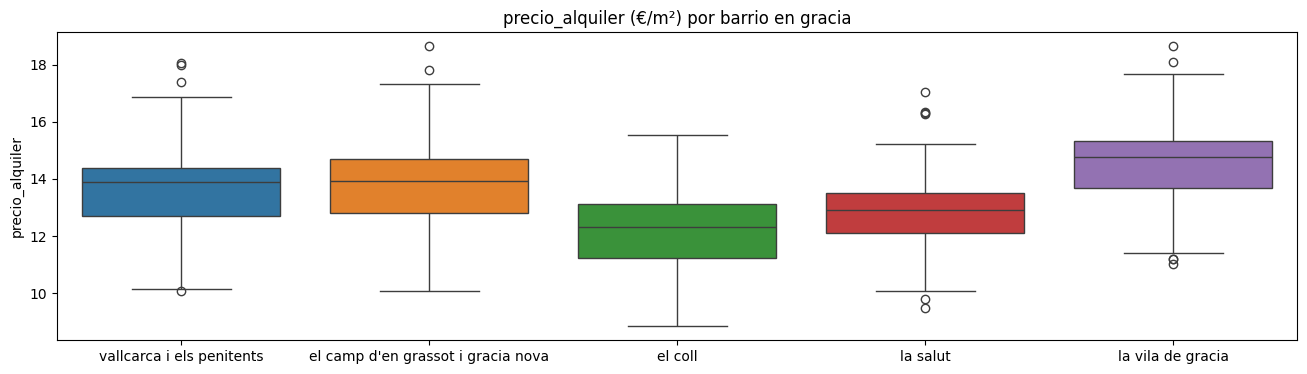

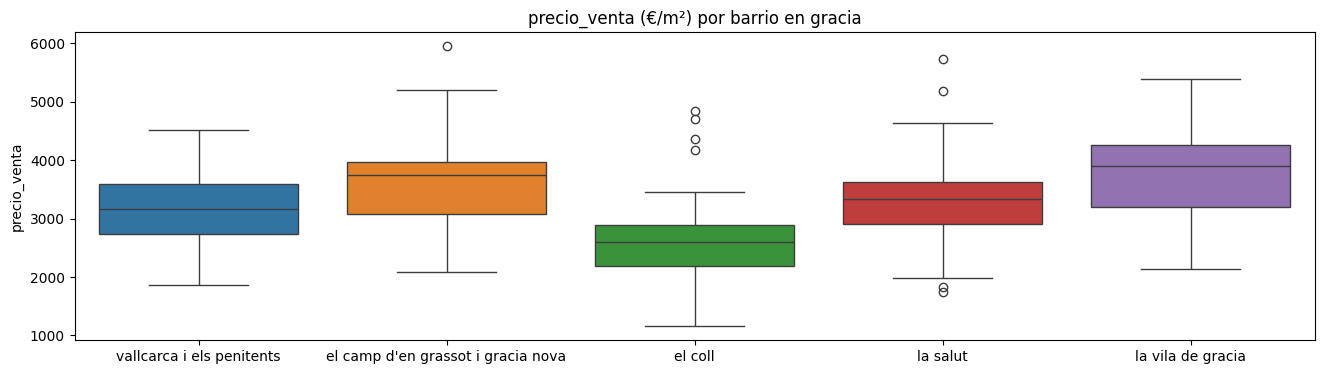

In [ ]:
for y in ['precio_alquiler', 'precio_venta']:
    fig = plt.figure(figsize=(16, 4))
    sns.boxplot(bcn_precios[bcn_precios['tipo'] == 'districte'], x='nombre', y=y, hue='nombre')
    plt.xlabel("")
    plt.title(f'{y} (€/m²) por distrito')
    plt.show()


for dist in bcn_precios['nom_districte'].dropna().unique().tolist():
    for y in ['precio_alquiler', 'precio_venta']:
        fig = plt.figure(figsize=(16, 4))
        sns.boxplot(bcn_precios[(bcn_precios_int['nom_districte'] == dist) & (bcn_precios_int['tipo'] == 'barri')], x='nombre', y=y, hue='nombre')
        plt.xlabel("")
        plt.title(f'{y} (€/m²) por barrio en {dist}')
        plt.show()


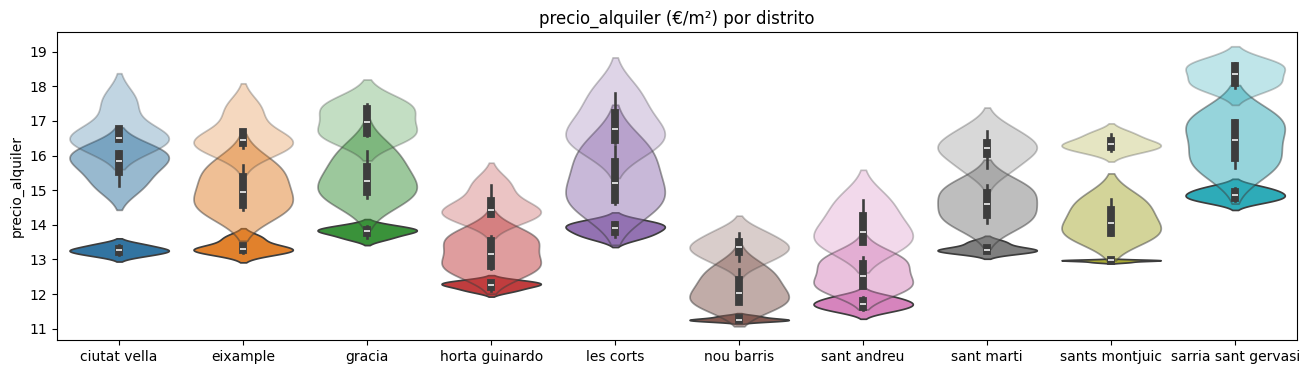

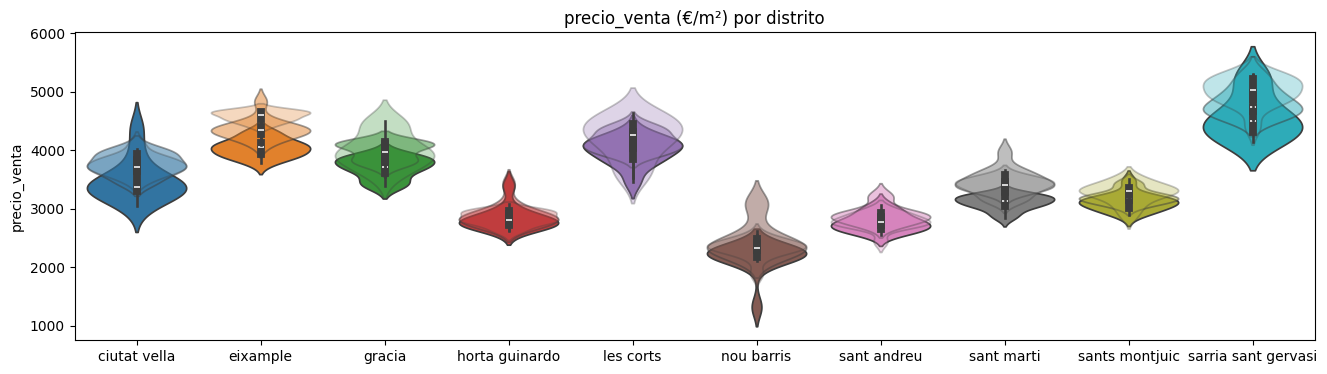

In [ ]:
for y in ['precio_alquiler', 'precio_venta']:
    fig = plt.figure(figsize=(16, 4))
    sns.violinplot(bcn_precios[(bcn_precios['tipo'] == 'districte') & (bcn_precios['mes'].dt.year == 2021)], x='nombre', y=y, hue='nombre', split=False)
    sns.violinplot(bcn_precios[(bcn_precios['tipo'] == 'districte') & (bcn_precios['mes'].dt.year == 2022)], x='nombre', y=y, hue='nombre', split=False, alpha=0.5)
    sns.violinplot(bcn_precios[(bcn_precios['tipo'] == 'districte') & (bcn_precios['mes'].dt.year == 2023)], x='nombre', y=y, hue='nombre', split=False, alpha=0.3)
    plt.xlabel("")
    plt.title(f'{y} (€/m²) por distrito')
    plt.show()

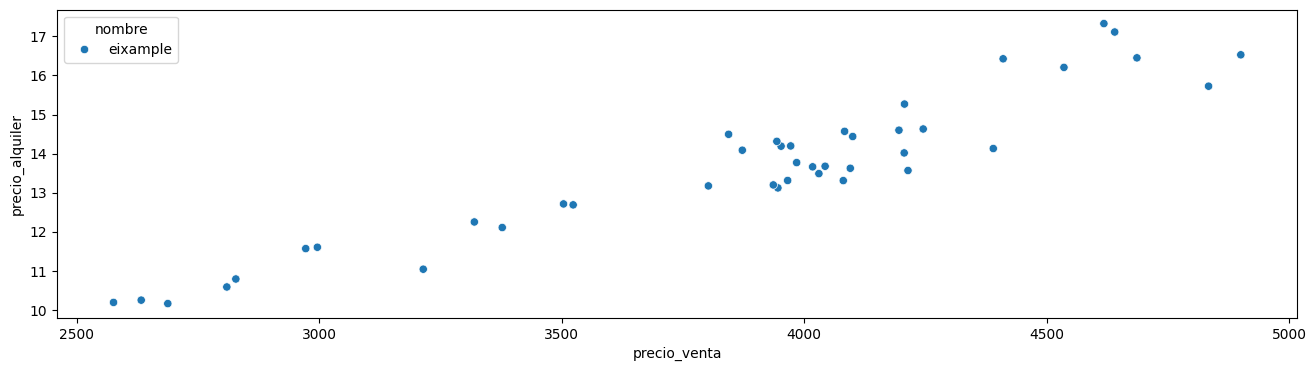

In [ ]:
fig = plt.figure(figsize=(16, 4))
sns.scatterplot(bcn_precios[bcn_precios['nombre'] =='eixample'], x='precio_venta', y='precio_alquiler', hue='nombre')
plt.show()


In [ ]:
bcn_precios_barri = bcn_precios[bcn_precios['tipo'] == 'barri' ].drop('tipo', axis=1).copy()
bcn_precios_dist = bcn_precios[bcn_precios['tipo'] == 'districte' ].drop('tipo', axis=1).copy()
bcn_precios_muni = bcn_precios[bcn_precios['tipo'] == 'municipi' ].drop('tipo', axis=1).copy()

bcn_precios_dist


hood_qtr = bcn_precios_barri.dropna().pivot(index='nombre', columns='mes', values='precio_alquiler').reset_index()
dist_qtr = bcn_precios_dist.dropna().pivot(index='nombre', columns='mes', values='precio_alquiler').reset_index()
town_qtr = bcn_precios_muni.dropna().pivot(index='nombre', columns='mes', values='precio_alquiler').reset_index()

display(dist_qtr[dist_qtr['nombre'] == 'ciutat vella'].round(2).reset_index(drop=True))
display(hood_qtr[hood_qtr['nombre'].isin(bcn_precios[bcn_precios['nom_districte'] == 'ciutat vella']['nombre'])].round(2).reset_index(drop=True))

mes        nombre  2014-01-01 00:00:00+00:00  2014-04-01 00:00:00+00:00  \
0    ciutat vella                      11.38                      11.29   

mes  2014-07-01 00:00:00+00:00  2014-10-01 00:00:00+00:00  \
0                        11.19                      11.63   

mes  2015-01-01 00:00:00+00:00  2015-04-01 00:00:00+00:00  \
0                         12.1                      12.13   

mes  2015-07-01 00:00:00+00:00  2015-10-01 00:00:00+00:00  \
0                        13.02                      12.88   

mes  2016-01-01 00:00:00+00:00  ...  2022-01-01 00:00:00+00:00  \
0                        13.59  ...                      16.02   

mes  2022-04-01 00:00:00+00:00  2022-07-01 00:00:00+00:00  \
0                        15.12                      16.12   

mes  2022-10-01 00:00:00+00:00  2023-01-01 00:00:00+00:00  \
0                        15.65                      16.52   

mes  2023-04-01 00:00:00+00:00  2023-07-01 00:00:00+00:00  \
0                        16.48                      16.42   

mes  2023-10-01 00:00:00+00:00  2024-01-01 00:00:00+00:00  \
0                        17.55                      17.09   

mes  2024-04-01 00:00:00+00:00  
0                        16.25  

[1 rows x 43 columns]

mes                                 nombre  2014-01-01 00:00:00+00:00  \
0                           el barri gotic                      10.56   
1                                 el raval                      10.62   
2                           la barceloneta                      14.78   
3    sant pere, santa caterina i la ribera                      11.12   

mes  2014-04-01 00:00:00+00:00  2014-07-01 00:00:00+00:00  \
0                        10.18                      10.99   
1                        10.52                       9.84   
2                        14.53                      15.54   
3                        11.23                      11.59   

mes  2014-10-01 00:00:00+00:00  2015-01-01 00:00:00+00:00  \
0                        10.41                      10.83   
1                        10.81                      10.85   
2                        16.14                      16.00   
3                        11.09                      12.10   

mes  2015-04-01 00:00:00+00:00  2015-07-01 00:00:00+00:00  \
0                        11.07                      11.72   
1                        10.92                      11.35   
2                        16.00                      17.07   
3                        12.02                      13.82   

mes  2015-10-01 00:00:00+00:00  2016-01-01 00:00:00+00:00  ...  \
0                        11.64                      13.26  ...   
1                        11.47                      11.96  ...   
2                        16.66                      17.74  ...   
3                        13.43                      13.52  ...   

mes  2022-01-01 00:00:00+00:00  2022-04-01 00:00:00+00:00  \
0                        16.44                      14.70   
1                        15.38                      14.66   
2                        20.03                      16.61   
3                        15.68                      15.82   

mes  2022-07-01 00:00:00+00:00  2022-10-01 00:00:00+00:00  \
0                        15.81                      14.75   
1                        15.37                      15.30   
2                        17.65                      19.63   
3                        17.02                      16.11   

mes  2023-01-01 00:00:00+00:00  2023-04-01 00:00:00+00:00  \
0                        16.53                      16.61   
1                        15.85                      15.27   
2                        18.47                      18.30   
3                        17.03                      17.63   

mes  2023-07-01 00:00:00+00:00  2023-10-01 00:00:00+00:00  \
0                         15.5                      16.98   
1                         15.6                      17.10   
2                         19.9                        NaN   
3                         17.7                      17.90   

mes  2024-01-01 00:00:00+00:00  2024-04-01 00:00:00+00:00  
0                        16.17                      15.30  
1                        16.57                      15.11  
2                        21.31                      20.36  
3                        17.59                      17.68  

[4 rows x 43 columns]

In [ ]:
import re
ideal = pd.read_csv('datasets/idealista_datafile.csv')
ideal.head()


link type_v  \
0  /inmueble/106596114/   Piso   
1  /inmueble/106592827/   Piso   
2  /inmueble/106590362/   Piso   
3  /inmueble/106586185/   Piso   
4  /inmueble/106585942/   Piso   

                                             address  \
0  Ciutat Meridiana - Torre Baró - Vallbona, Barc...   
1  calle del Pare Manjón, La Trinitat Vella, Barc...   
2   calle de Vidal i Guasch, Les Roquetes, Barcelona   
3            calle de Palerm, 6, El Besòs, Barcelona   
4  calle de Vallcivera, 22, Ciutat Meridiana - To...   

                                                town   price  price_old  \
0  Ciutat Meridiana - Torre Baró - Vallbona, Barc...  69.875        NaN   
1  calle del Pare Manjón, La Trinitat Vella, Barc...  69.000        NaN   
2   calle de Vidal i Guasch, Les Roquetes, Barcelona  95.000        NaN   
3            calle de Palerm, 6, El Besòs, Barcelona  88.500        NaN   
4  calle de Vallcivera, 22, Ciutat Meridiana - To...  95.200        NaN   

                                                info  \
0  ['2 hab.', '54 m²', 'Planta 5ª exterior sin as...   
1      ['3 hab.', '41 m²', 'Planta -1 sin ascensor']   
2  ['2 hab.', '65 m²', 'Planta 1ª exterior sin as...   
3  ['3 hab.', '54 m²', 'Planta 2ª interior con as...   
4  ['3 hab.', '66 m²', 'Planta 2ª interior con as...   

                                         description                 tags  \
0  <p class="ellipsis">INMUEBLE SIN POSESION / VI...                  NaN   
1  <p class="ellipsis">Oportunidad sólo para inve...                  NaN   
2  <p class="ellipsis">Housfy vende piso alquilad...                  NaN   
3  <p class="ellipsis">Inmueble ocupado ideal par...  Ocupada ilegalmente   
4  <p class="ellipsis">Inmueble ocupado ideal par...  Ocupada ilegalmente   

   agent              created  
0    NaN  2024-11-20 14:42:36  
1    NaN  2024-11-20 14:42:36  
2    NaN  2024-11-20 14:42:36  
3    NaN  2024-11-20 14:42:36  
4    NaN  2024-11-20 14:42:36

In [ ]:

hab_rx = re.compile(r'\'(\d+?) hab\.\'')
m2_rx = re.compile(r'\'(\d+?) m²\'')
barrio_rx = re.compile(r"([^,]+),[^,]+$")

def get_hood(x):
    x1 = ''.join(barrio_rx.findall(x)).strip() 
    x1 = x1 if len(x1)>1 else x
    return estandarizar(x1)

ideal['n_hab'] = ideal['info'].map(lambda x: ''.join(hab_rx.findall(x)))
ideal['sup_m2'] = ideal['info'].map(lambda x: ''.join(m2_rx.findall(x)))
ideal['town'] = ideal['town'].map(get_hood)
ideal['description'] = ideal['description'].map(lambda x: re.sub(r"<.*?>", "", x))
ideal[['type_v','address', 'description']] = ideal[['type_v','address', 'description']].applymap(estandarizar)


ideal


link   type_v  \
0    /inmueble/106596114/     piso   
1    /inmueble/106592827/     piso   
2    /inmueble/106590362/     piso   
3    /inmueble/106586185/     piso   
4    /inmueble/106585942/     piso   
..                    ...      ...   
350  /inmueble/101127284/     piso   
351  /inmueble/104221726/     piso   
352  /inmueble/106627206/  estudio   
353  /inmueble/106625212/  estudio   
354  /inmueble/106625063/  estudio   

                                               address  \
0    ciutat meridiana  torre baro  vallbona, barcelona   
1    calle del pare manjon, la trinitat vella, barc...   
2     calle de vidal i guasch, les roquetes, barcelona   
3              calle de palerm, 6, el besos, barcelona   
4    calle de vallcivera, 22, ciutat meridiana  tor...   
..                                                 ...   
350  ciutat meridiana  torre baro  vallbona, barcelona   
351  calle de la foradada, la trinitat vella, barce...   
352          calle de granollers, el carmel, barcelona   
353      plaza de les palmeres, sant andreu, barcelona   
354          calle de granollers, el carmel, barcelona   

                                       town    price  price_old  \
0    ciutat meridiana  torre baro  vallbona   69.875        NaN   
1                         la trinitat vella   69.000        NaN   
2                              les roquetes   95.000        NaN   
3                                  el besos   88.500        NaN   
4    ciutat meridiana  torre baro  vallbona   95.200        NaN   
..                                      ...      ...        ...   
350  ciutat meridiana  torre baro  vallbona   98.000        NaN   
351                       la trinitat vella  100.000        NaN   
352                               el carmel   89.000        NaN   
353                             sant andreu   95.000        NaN   
354                               el carmel   89.000        NaN   

                                                  info  \
0    ['2 hab.', '54 m²', 'Planta 5ª exterior sin as...   
1        ['3 hab.', '41 m²', 'Planta -1 sin ascensor']   
2    ['2 hab.', '65 m²', 'Planta 1ª exterior sin as...   
3    ['3 hab.', '54 m²', 'Planta 2ª interior con as...   
4    ['3 hab.', '66 m²', 'Planta 2ª interior con as...   
..                                                 ...   
350                  ['3 hab.', '64 m²', 'Planta 5ª ']   
351               ['3 hab.', '92 m²', ' sin ascensor']   
352            ['34 m²', 'Bajo exterior sin ascensor']   
353            ['38 m²', 'Bajo exterior con ascensor']   
354            ['34 m²', 'Bajo exterior sin ascensor']   

                                           description                 tags  \
0    inmueble sin posesion / vivienda okupada!**sol...                  NaN   
1    oportunidad solo para inversores. el activo se...                  NaN   
2    housfy vende piso alquilado con una rentabilid...                  NaN   
3    inmueble ocupado ideal para invertir,imposibil...  Ocupada ilegalmente   
4    inmueble ocupado ideal para invertir,imposibil...  Ocupada ilegalmente   
..                                                 ...                  ...   
350  piso en barcelona, idoneo para familias. la vi...                  NaN   
351  piso de 93 m², de 32 dormitorios y 1 banos, en...                  NaN   
352  nos complace ofrecer este estudio a la venta, ...                  NaN   
353  grupo a&b presenta esta local estudio a la ven...                  NaN   
354  tenemos el agrado de presentar este estudio a ...                  NaN   

     agent              created n_hab sup_m2  
0      NaN  2024-11-20 14:42:36     2     54  
1      NaN  2024-11-20 14:42:36     3     41  
2      NaN  2024-11-20 14:42:36     2     65  
3      NaN  2024-11-20 14:42:36     3     54  
4      NaN  2024-11-20 14:42:36     3     66  
..     ...                  ...   ...    ...  
350    NaN  2024-11-28 16:12:48     3     64  
351    NaN  2024-11-28 16:12:48     3   

In [ ]:
from difflib import SequenceMatcher
places = barrios['nom_barri'].unique().tolist() + barrios['nom_districte'].unique().tolist()

# tipo	precio	codi_districte	nom_districte	codi_barri
def find_place(x):
    match = None
    best = 0
    for y in places:
        ratio = SequenceMatcher(None, x, y).ratio()
        if ratio == 1:
            return (y, ratio)
        if ratio > best:
            best = ratio
            match = y
    return (match if best > 0.5 else None, round(best,2))


ideal[['barrio', 'barrio_ratio']] = pd.DataFrame(ideal['town'].map(find_place).tolist(), index=ideal.index)
ideal

link   type_v  \
0    /inmueble/106596114/     piso   
1    /inmueble/106592827/     piso   
2    /inmueble/106590362/     piso   
3    /inmueble/106586185/     piso   
4    /inmueble/106585942/     piso   
..                    ...      ...   
350  /inmueble/101127284/     piso   
351  /inmueble/104221726/     piso   
352  /inmueble/106627206/  estudio   
353  /inmueble/106625212/  estudio   
354  /inmueble/106625063/  estudio   

                                               address  \
0    ciutat meridiana  torre baro  vallbona, barcelona   
1    calle del pare manjon, la trinitat vella, barc...   
2     calle de vidal i guasch, les roquetes, barcelona   
3              calle de palerm, 6, el besos, barcelona   
4    calle de vallcivera, 22, ciutat meridiana  tor...   
..                                                 ...   
350  ciutat meridiana  torre baro  vallbona, barcelona   
351  calle de la foradada, la trinitat vella, barce...   
352          calle de granollers, el carmel, barcelona   
353      plaza de les palmeres, sant andreu, barcelona   
354          calle de granollers, el carmel, barcelona   

                                       town    price  price_old  \
0    ciutat meridiana  torre baro  vallbona   69.875        NaN   
1                         la trinitat vella   69.000        NaN   
2                              les roquetes   95.000        NaN   
3                                  el besos   88.500        NaN   
4    ciutat meridiana  torre baro  vallbona   95.200        NaN   
..                                      ...      ...        ...   
350  ciutat meridiana  torre baro  vallbona   98.000        NaN   
351                       la trinitat vella  100.000        NaN   
352                               el carmel   89.000        NaN   
353                             sant andreu   95.000        NaN   
354                               el carmel   89.000        NaN   

                                                  info  \
0    ['2 hab.', '54 m²', 'Planta 5ª exterior sin as...   
1        ['3 hab.', '41 m²', 'Planta -1 sin ascensor']   
2    ['2 hab.', '65 m²', 'Planta 1ª exterior sin as...   
3    ['3 hab.', '54 m²', 'Planta 2ª interior con as...   
4    ['3 hab.', '66 m²', 'Planta 2ª interior con as...   
..                                                 ...   
350                  ['3 hab.', '64 m²', 'Planta 5ª ']   
351               ['3 hab.', '92 m²', ' sin ascensor']   
352            ['34 m²', 'Bajo exterior sin ascensor']   
353            ['38 m²', 'Bajo exterior con ascensor']   
354            ['34 m²', 'Bajo exterior sin ascensor']   

                                           description                 tags  \
0    inmueble sin posesion / vivienda okupada!**sol...                  NaN   
1    oportunidad solo para inversores. el activo se...                  NaN   
2    housfy vende piso alquilado con una rentabilid...                  NaN   
3    inmueble ocupado ideal para invertir,imposibil...  Ocupada ilegalmente   
4    inmueble ocupado ideal para invertir,imposibil...  Ocupada ilegalmente   
..                                                 ...                  ...   
350  piso en barcelona, idoneo para familias. la vi...                  NaN   
351  piso de 93 m², de 32 dormitorios y 1 banos, en...                  NaN   
352  nos complace ofrecer este estudio a la venta, ...                  NaN   
353  grupo a&b presenta esta local estudio a la ven...                  NaN   
354  tenemos el agrado de presentar este estudio a ...                  NaN   

     agent              created n_hab sup_m2             barrio  barrio_ratio  
0      NaN  2024-11-20 14:42:36     2     54   ciutat meridiana          0.59  
1      NaN  2024-11-20 14:42:36     3     41  la trinitat vella          1.00  
2      NaN  2024-11-20 14:42:36     2     65       les roquetes          1.00  
3      NaN  2024-11-20 14:42:36     3     54        el poblenou          0.63  
4      NaN  2024

In [ ]:
!pip install gradio_client

from gradio_client import Client, handle_file

def connect_gradio(endpoint, mode, system_prompt):
    # mode Literal['RAG', 'Search', 'Basic', 'Summarize'] Default: "RAG"
    client = Client(endpoint)
    client.predict(api_name="/_set_current_mode", mode=mode)
    client.predict(api_name="/_set_system_prompt", system_prompt_input=system_prompt)
    return client

endpoint = "http://0.0.0.0:8001/"
mode="Basic"
system_prompt = "eres un clasificador de viviendas que tienes que decidir cual de estas 3 categoría es la más probable: [disponible, alquilada, ocupada]. Solo debes responder con una palabra, sin saludos ni otros comentarios."
# client = connect_gradio(endpoint, mode, system_prompt)

In [ ]:

def get_occupation(description):
    try:
        return client.predict(api_name="/chat", message=description, mode="Basic",param_3=[handle_file('https://github.com/gradio-app/gradio/raw/main/test/test_files/sample_file.pdf')],param_4="")
    finally:
        return None

# ideal[ideal['ocupacion'] is None]['ocupacion'] = ideal.description.map(lambda x: get_occupation(x))

ideal

link   type_v  \
0    /inmueble/106596114/     piso   
1    /inmueble/106592827/     piso   
2    /inmueble/106590362/     piso   
3    /inmueble/106586185/     piso   
4    /inmueble/106585942/     piso   
..                    ...      ...   
350  /inmueble/101127284/     piso   
351  /inmueble/104221726/     piso   
352  /inmueble/106627206/  estudio   
353  /inmueble/106625212/  estudio   
354  /inmueble/106625063/  estudio   

                                               address  \
0    ciutat meridiana  torre baro  vallbona, barcelona   
1    calle del pare manjon, la trinitat vella, barc...   
2     calle de vidal i guasch, les roquetes, barcelona   
3              calle de palerm, 6, el besos, barcelona   
4    calle de vallcivera, 22, ciutat meridiana  tor...   
..                                                 ...   
350  ciutat meridiana  torre baro  vallbona, barcelona   
351  calle de la foradada, la trinitat vella, barce...   
352          calle de granollers, el carmel, barcelona   
353      plaza de les palmeres, sant andreu, barcelona   
354          calle de granollers, el carmel, barcelona   

                                       town    price  price_old  \
0    ciutat meridiana  torre baro  vallbona   69.875        NaN   
1                         la trinitat vella   69.000        NaN   
2                              les roquetes   95.000        NaN   
3                                  el besos   88.500        NaN   
4    ciutat meridiana  torre baro  vallbona   95.200        NaN   
..                                      ...      ...        ...   
350  ciutat meridiana  torre baro  vallbona   98.000        NaN   
351                       la trinitat vella  100.000        NaN   
352                               el carmel   89.000        NaN   
353                             sant andreu   95.000        NaN   
354                               el carmel   89.000        NaN   

                                                  info  \
0    ['2 hab.', '54 m²', 'Planta 5ª exterior sin as...   
1        ['3 hab.', '41 m²', 'Planta -1 sin ascensor']   
2    ['2 hab.', '65 m²', 'Planta 1ª exterior sin as...   
3    ['3 hab.', '54 m²', 'Planta 2ª interior con as...   
4    ['3 hab.', '66 m²', 'Planta 2ª interior con as...   
..                                                 ...   
350                  ['3 hab.', '64 m²', 'Planta 5ª ']   
351               ['3 hab.', '92 m²', ' sin ascensor']   
352            ['34 m²', 'Bajo exterior sin ascensor']   
353            ['38 m²', 'Bajo exterior con ascensor']   
354            ['34 m²', 'Bajo exterior sin ascensor']   

                                           description                 tags  \
0    inmueble sin posesion / vivienda okupada!**sol...                  NaN   
1    oportunidad solo para inversores. el activo se...                  NaN   
2    housfy vende piso alquilado con una rentabilid...                  NaN   
3    inmueble ocupado ideal para invertir,imposibil...  Ocupada ilegalmente   
4    inmueble ocupado ideal para invertir,imposibil...  Ocupada ilegalmente   
..                                                 ...                  ...   
350  piso en barcelona, idoneo para familias. la vi...                  NaN   
351  piso de 93 m², de 32 dormitorios y 1 banos, en...                  NaN   
352  nos complace ofrecer este estudio a la venta, ...                  NaN   
353  grupo a&b presenta esta local estudio a la ven...                  NaN   
354  tenemos el agrado de presentar este estudio a ...                  NaN   

     agent              created n_hab sup_m2             barrio  barrio_ratio  
0      NaN  2024-11-20 14:42:36     2     54   ciutat meridiana          0.59  
1      NaN  2024-11-20 14:42:36     3     41  la trinitat vella          1.00  
2      NaN  2024-11-20 14:42:36     2     65       les roquetes          1.00  
3      NaN  2024-11-20 14:42:36     3     54        el poblenou          0.63  
4      NaN  2024

In [ ]:
# ideal.to_csv('datasets/idealista_datafile_new.csv', index=False)